# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [3]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [4]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(14.24, '2023-05-29')

(11.2,
 59    2023-08-22
 Name: date, dtype: object)

9 -0.05 -0.41
Bear
-0.41


### regression_line(X, Y)
regression_ratio(df, window=10):

14.83 -0.07
Above
-0.07


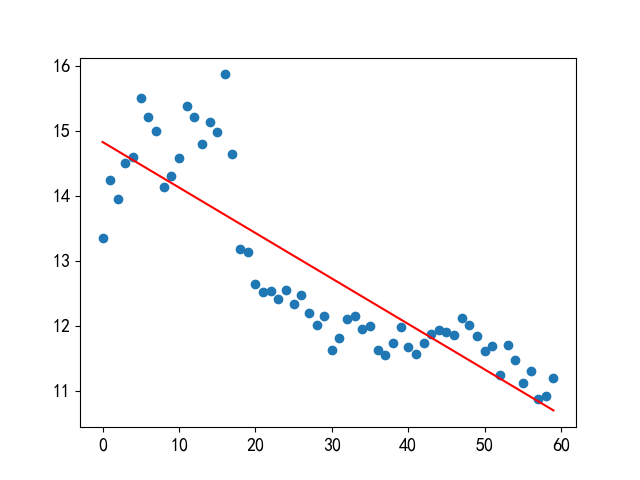

In [5]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [6]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'top10', 'ma5dcum', 'ra', 'hmax', 'max5', 'lmin', 'min5', 'cmean', 'hv',
       'lv'],
      dtype='object', length=112)

### check_postion_vol_price

In [7]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code  open  high    low  close          vol        amount  \
59  2023-08-22  601360  11.0  11.2  10.85   11.2  105896900.0  1.167585e+09   

     ma5d  ma10d  ...  ma5dcum  ra   hmax   max5   lmin   min5  cmean  \
59  11.08  11.32  ...     11.4  10  15.87  11.71  10.85  11.03  11.06   

             hv          lv  Positon  
59  566954066.0  18433199.0  Neutral  

[1 rows x 113 columns]

In [8]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'ma5dcum', 'ra', 'hmax', 'max5', 'lmin', 'min5', 'cmean', 'hv', 'lv',
       'Positon'],
      dtype='object', length=113)

0    2023-05-29
1    2023-05-30
2    2023-05-31
Name: date, dtype: object

59   2023-08-22
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:-0.07 


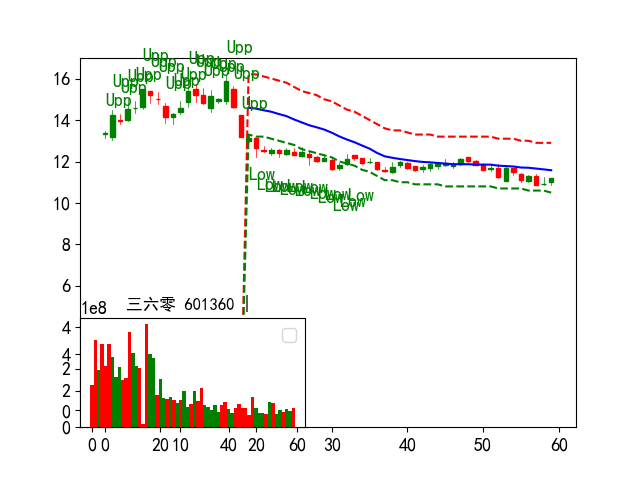

In [9]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'b', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [10]:
'code' in dfc.columns

True

### show_channel_mpl

In [11]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [12]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None):
    col_src = [
        "name", "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name]
    return temp


def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [13]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.02,
        ma_250_h=1.11, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().market('all').index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    # df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20150501', end=None, freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration(
        h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
        freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)

    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'w'

In [14]:
resample = 'W-FRI'
# resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.02,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 4965
6.08 (4963,) 301398 (161, 6)
resample:W-FRI
use time:23.55


In [15]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open   high    low  close         vol       amount
date                                                           
2023-08-25  13.99  14.11  13.88  14.02  45881241.0  642001394.0

### Test InStock

In [16]:
df.loc['301083']

open   high    low  close         vol        amount
date                                                            
2021-12-17  19.04  19.07  18.12  18.22   4046124.0  7.507724e+07
2021-12-24  17.49  17.50  16.59  16.60   3024670.0  5.118218e+07
2021-12-31  17.22  17.44  17.14  17.16   1610690.0  2.786333e+07
2022-01-07  17.41  17.54  16.85  16.95   1721200.0  2.961089e+07
2022-01-14  17.91  18.23  17.63  18.18   3364032.0  6.051730e+07
...           ...    ...    ...    ...         ...           ...
2023-07-28  18.44  18.44  17.84  17.86   3178784.0  5.722591e+07
2023-08-04  17.04  17.42  16.93  17.20   3852130.0  6.616555e+07
2023-08-11  17.33  17.46  16.95  16.96   3426500.0  5.898997e+07
2023-08-18  17.54  17.83  17.00  17.13   5448500.0  9.530633e+07
2023-08-25  17.49  18.28  17.28  18.16  12519122.0  2.234535e+08

[86 rows x 6 columns]

## ra_diff

In [18]:
df = df.groupby(level=[0]).tail(30).groupby(level=[0]).apply(ra_diff)


In [19]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(30, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [20]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [21]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [22]:
# df.loc['000002'][-10:]

## sina_dm

In [23]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2023-08-21',
 code
 000689    ST宏业
 Name: name, dtype: object)

In [24]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2023-08/22/23 20:14:12'

code
688350   2023-08-22 15:02:27
603898   2023-08-22 15:00:01
Name: ticktime, dtype: datetime64[ns]

314.18590778509775

### Combine ratio and idx

if 'date' in df.columns:
    print('error duplicated date col')
    if isinstance(df,pd.MultiIndex):
        df.drop('date', axis=1, inplace=True)
else:
    df = df.reset_index().set_index('code')
    df['idx'] = df_idx_detect
    df['xratio'] = df_reg_ratio
    df['name'] = sina_dm.name
    df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [25]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [26]:
# tdx_path = "G:\\tdx_last_df.h5"
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
# h5[:1]
code_muti = '600519'
# h5.loc[code_muti][:2]

freq = 'D'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()

run_col = ['close', 'volume']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol / 1000 / 1000 / 1000
mdf['amount']=mdf['volume'].apply(lambda x: round(x /100,2)) 
mdf['vol']=(mdf.volume / mdf.close).map(lambda x: round(x/100, 2))
mdf['volume'] = mdf.volume.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')

['/all_10']
G:\sina_MultiIndex_data.h5


(1366715, 6)

11769.411048875998

In [27]:
mdf.loc['000002']

ticktime    2023-08-23 00:00:00
close                 13.986364
volume                     0.06
amount              76211296.54
vol                  5448971.48
Name: 000002, dtype: object

###  实时成交量个股Top

In [28]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [29]:
nowdf.shape,top20_nd

((4904, 5),
         volume  name
 code                
 601099    1.56   太平洋
 600050    1.44  中国联通
 000656    0.96  金科股份
 002310    0.85  东方园林
 601162    0.77  天风证券
 000982    0.70  中银绒业
 000826    0.70  启迪环境
 601728    0.59  中国电信
 601288    0.44  农业银行
 000010    0.42  美丽生态
 300059    0.41  东方财富
 000725    0.41  京东方Ａ
 601012    0.40  隆基绿能
 000980    0.40  众泰汽车
 600322    0.39  天房发展
 002146    0.37  荣盛发展
 002235    0.35  安妮股份
 601398    0.34  工商银行
 002528    0.34   英飞拓
 600602    0.34  云赛智联)

### 合并实时成交量及SinaDM

In [30]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm[:1]

name  open  llastp   now  trade  high    low   buy   sell    volume  \
code                                                                          
600079  人福医药  22.2   22.19  22.2    0.0  22.3  21.67  22.2  22.21  10610691   

        ...  b1_vv  close      nvol  lastbuy         timel   nlow  nhigh  \
code    ...                                                                
600079  ...  20300   22.2  10610691    22.03  1.692688e+09  21.67   22.3   

           nclose        vol      amount  
code                                      
600079  22.065468  837302.87  18475209.1  

[1 rows x 43 columns]

## check HDF LastDate

In [31]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(0, 7)

(4963, 7)

In [32]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open       high        low      close          vol  \
code   date                                                                  
999999 2023-08-25  3103.7807  3126.7838  3074.5307  3120.3338  309316335.0   

                         amount  ra_diff  
code   date                               
999999 2023-08-25  3.486377e+11      1.0

In [33]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [34]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [35]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [36]:
dfs=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [37]:
# dfs.loc['000002'][-5:].upper
dfs.loc['603357'][-5:][['close','upper','low','boll']]
dftemp = dfs.loc['603357']
dftemp[dftemp.close > dftemp.upper]

close  upper    low   boll
date                                  
2023-07-28  10.72  14.95  10.52  11.90
2023-08-04  10.63  14.93  10.48  11.92
2023-08-11   9.85  14.98   9.81  11.89
2023-08-18   9.59  15.05   9.57  11.80
2023-08-25   9.82  15.09   9.60  11.74

Empty DataFrame
Columns: [open, high, low, close, vol, amount, ra_diff, ma5, ma10, ma20, upper, lower, boll, hmax, lmin, hat, perc1d, perc2d, perc3d, perc4d, perc5d, vol1d, vol2d, vol3d, vol4d, vol5d, volsum5d]
Index: []

[0 rows x 27 columns]

In [38]:
# dfs.loc['688027']
dfs['ma51d'] = round(dfs['close'].rolling(5).mean(), 2)
show_tdx_data(dfs.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 28


ra_diff     hat    close  volsum5d     hmax     lmin  perc1d  \
date                                                                       
2023-08-18     1.08  271.33  1802.59      46.9  1906.52  1636.11   -1.71   
2023-08-25     1.07  270.98  1788.00      -8.8  1906.52  1636.11   -0.81   

               ma20  vol1d  vol2d  vol3d  vol4d   vol5d  perc3d  perc5d  \
date                                                                      
2023-08-18  1751.85 -36.45   9.00 -37.02  -0.91  112.27   -4.98    2.83   
2023-08-25  1751.70  56.55 -36.45   9.00 -37.02   -0.91   -5.57    0.94   

              ma51d  ra_diff  
date                          
2023-08-18  1839.67     1.08  
2023-08-25  1843.01     1.07

### Append Now SinaTo MultiIndex dfNow

In [39]:
cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    sina_today=sina_dm.copy()
    if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
        sina_today['date']=pd.to_datetime(cct.get_today())
        print('concat1 init:sina_today:%s'%(sina_today.index[0]))
        # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
        # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
        # sina_today['idx'] = df_idx_detect2
        # sina_today['xratio'] = df_reg_ratio2
        # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
        if 'vol' in sina_today.columns:
            sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
        else:
            sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

    if sina_today.index[0] not in df.index:
        # df.index=df.index.append(sina_dm.index)
        print('concat1:sina_today:%s %s'%(sina_today.index[0]))
        df = pd.concat([df, sina_today])


#         sina_today=sina_dm.copy()
#         #drop line and append idx
#         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
#             sina_today['date']=pd.to_datetime(cct.get_today())
#             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

#             sina_today['idx'] = df_idx_detect2
#             sina_today['xratio'] = df_reg_ratio2
#             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
#             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


#         df = get_multiIndex_drop_last_row(df,dropline=1)

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat2:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])
        df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfNow=get_Append_Sina_To_MultiTDX(dfs.groupby(level=[0]).tail(30),sinadm)
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfs.groupby(level=[0]).tail(30).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df.loc[code_df][-2:]


'2023-08-22'

In [40]:
# dfNow.loc['000002']

### Xratio and tail 30 MultiIndex 

In [41]:
# dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
df_xratio.index =df_xratio.to_frame().index.droplevel(1)
dfNow['xratio'] = df_xratio

In [42]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2023-08-18    8.74
2023-08-25    8.60
Name: upper, dtype: float64

xratio:0.01 ra_diff:1.55


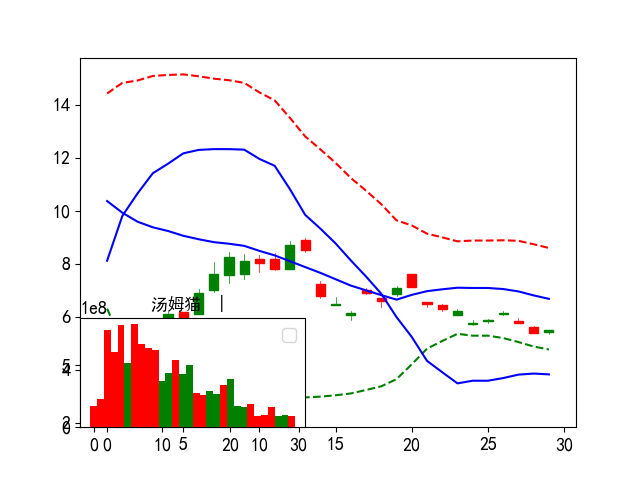

In [43]:
dfNow.loc['300459'][-2:].upper
show_ohlc_upper(dfNow.loc['300459'][-30:],code='300459')

601099 1.83
xratio:0.05 ra_diff:1.83


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


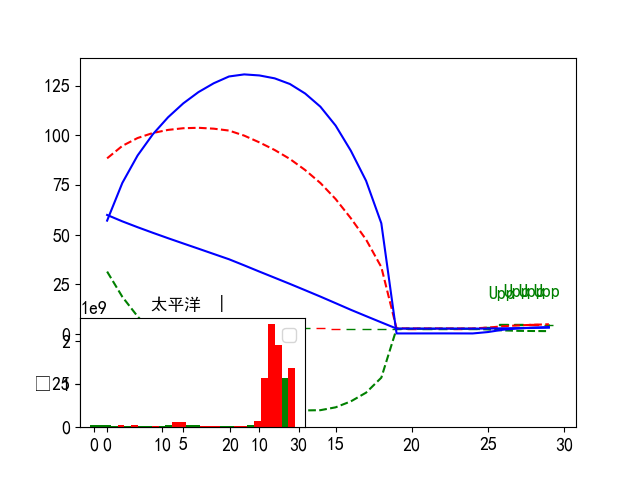

600050 1.17
xratio:-0.01 ra_diff:1.17


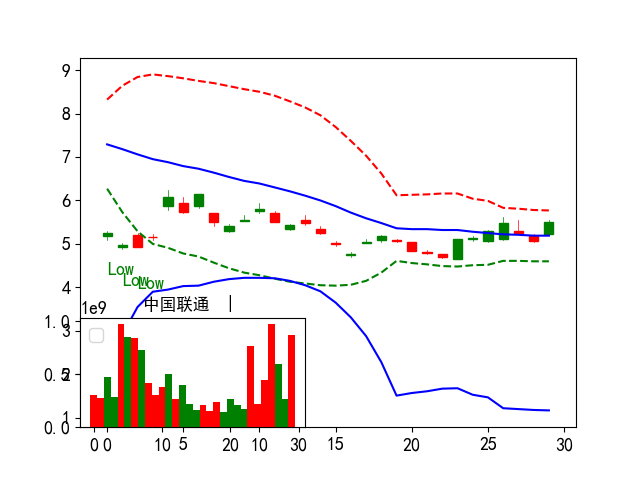

000656 2.13
xratio:-0.0 ra_diff:2.13


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


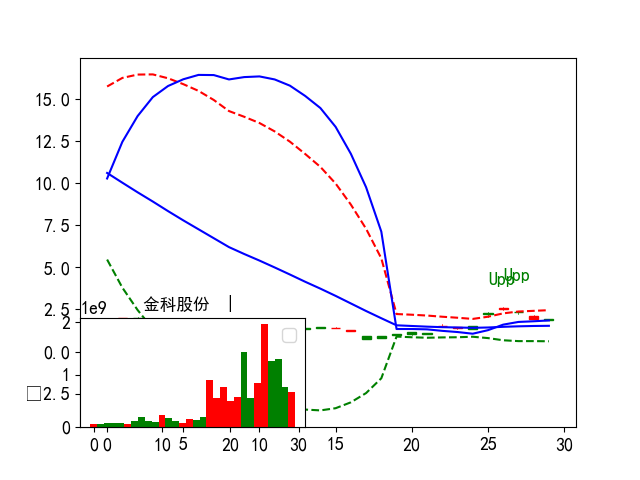

002310 1.73
xratio:0.01 ra_diff:1.73


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


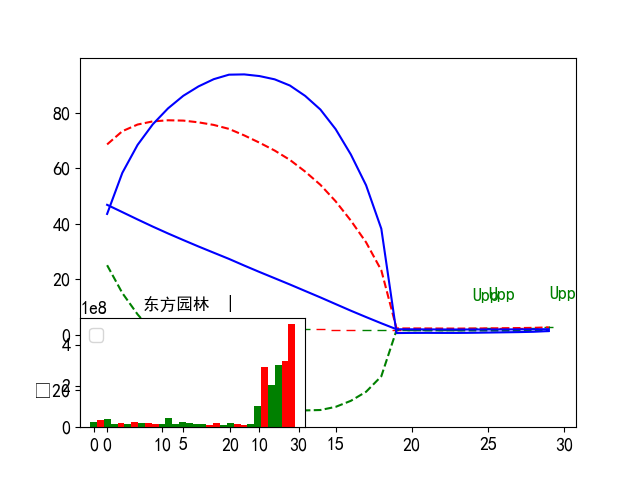

601162 1.26
xratio:0.02 ra_diff:1.26


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


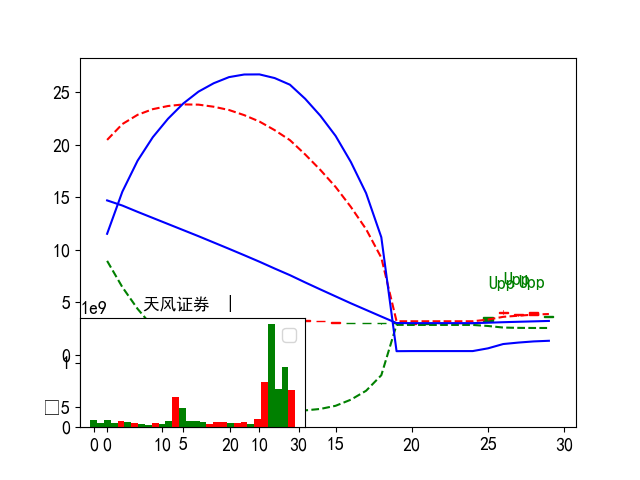

000982 1.23
xratio:-0.0 ra_diff:1.23


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


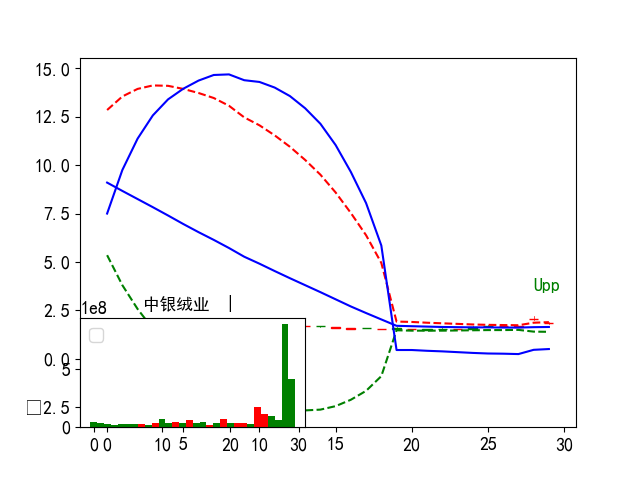

000826 1.86
xratio:-0.01 ra_diff:1.86


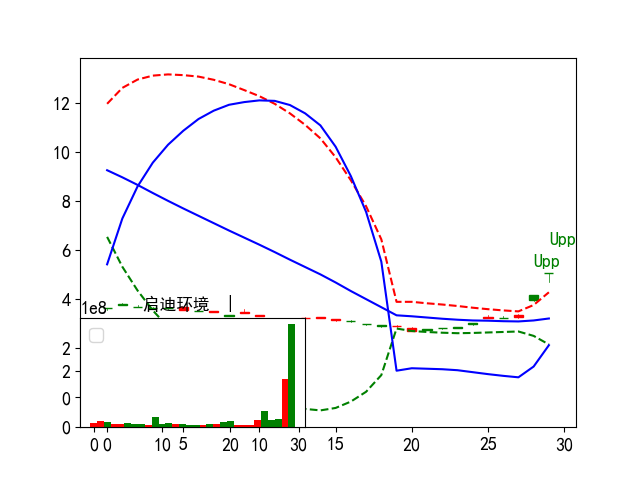

601728 1.2
xratio:-0.01 ra_diff:1.2


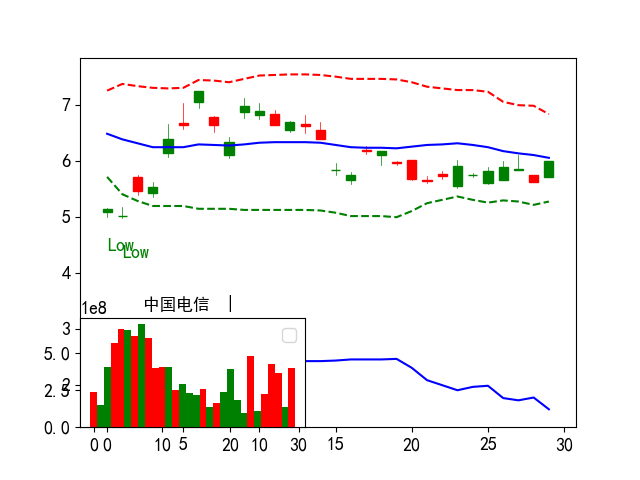

601288 1.2
xratio:0.02 ra_diff:1.2


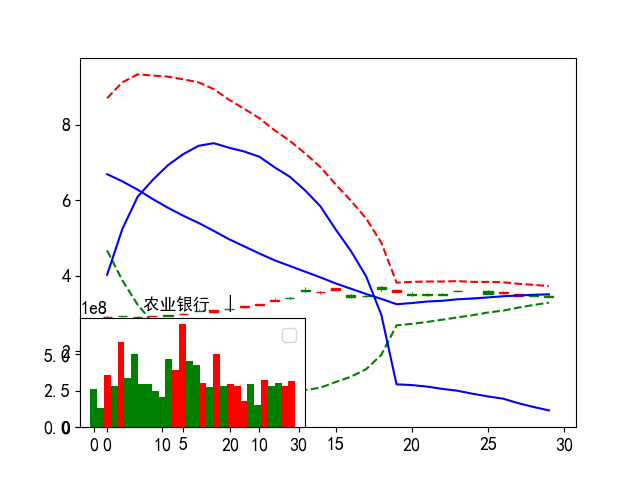

000010 1.69
xratio:-0.02 ra_diff:1.69


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


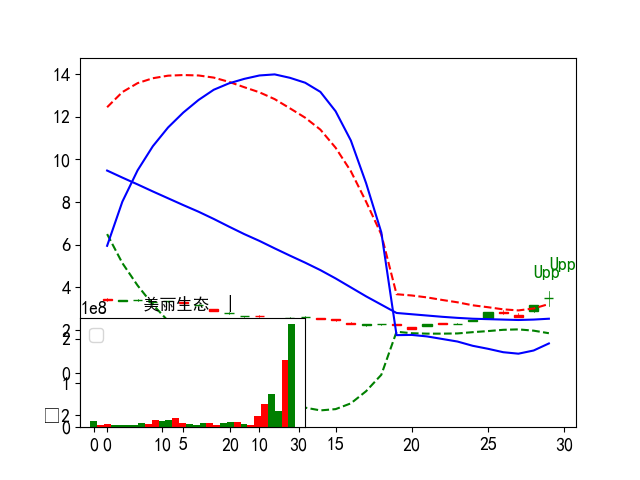

In [44]:
for co in top20_nd.index[:10]:
    print(co,dfNow.loc[co].ra_diff[-1])
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    show_ohlc_upper(dfNow.loc[co][-30:],co)

In [45]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date   open   high    low  close        vol       amount  \
code                                                                    
688789 2023-08-25  84.77  93.00  84.77  91.13  1897711.0  170457253.0   
688786 2023-08-25  42.49  42.49  41.06  42.30   173121.0    7226180.0   

        ra_diff    ma5   ma10  ...  perc5d   vol1d  vol2d  vol3d  vol4d  \
code                           ...                                        
688789     1.07  89.10  88.23  ...    1.12  230.22  80.01 -39.44   6.31   
688786     1.03  43.87  45.28  ...  -11.56   41.20 -56.12 -11.61 -29.97   

        vol5d  volsum5d  ma51d  xratio   idx  
code                                          
688789 -15.59     261.5  89.10   -4.62  3.49  
688786 -74.29    -130.8  43.87   -0.09 -3.10  

[2 rows x 31 columns]

In [46]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [47]:
df.loc['000002'][-2:]

open   high    low  close         vol        amount  ra_diff
date                                                                     
2023-08-18  14.51  14.67  14.31  14.31  55003215.0  7.966413e+08     1.04
2023-08-25  13.99  14.11  13.88  14.02  45881241.0  6.420014e+08     1.02

In [48]:
dfNow.loc['000002'][-2:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                        
2023-08-18  14.51  14.67  14.31  14.31  55003215.0  7.966413e+08     1.04   
2023-08-25  13.99  14.11  13.88  14.02  45881241.0  6.420014e+08     1.02   

              ma5   ma10   ma20  ...  perc5d  vol1d  vol2d  vol3d   vol4d  \
date                             ...                                        
2023-08-18  14.67  14.35  14.71  ...    3.85 -31.50 -33.96 -36.80  207.64   
2023-08-25  14.68  14.30  14.62  ...    0.29 -16.58 -31.50 -33.96  -36.80   

             vol5d  volsum5d  ma51d  xratio   idx  
date                                               
2023-08-18   31.25     136.6  14.67   -0.07 -0.23  
2023-08-25  207.64      88.8  14.68   -0.07  0.08  

[2 rows x 30 columns]

# 基础处理

In [49]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2023-08-22 2023-08-22


open   high    low  close         vol       amount  \
code   date                                                              
000002 2023-08-25  13.99  14.11  13.88  14.02  45881241.0  642001394.0   
000001 2023-08-25  11.38  11.45  11.31  11.37  60680809.0  689991238.0   

                   ra_diff    ma5  ma10   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                     ...                         
000002 2023-08-25     1.02  14.68  14.3  14.62  ...    0.29 -16.58 -31.50   
000001 2023-08-25     1.02  11.88  11.6  11.97  ...    0.26  -8.03 -30.07   

                   vol3d  vol4d   vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                             
000002 2023-08-25 -33.96 -36.80  207.64      88.8  14.68   -0.07  0.08  
000001 2023-08-25 -27.59 -44.48  522.38     412.2  11.88   -0.06  0.02  

[2 rows x 30 columns]

Low:2023-08-22


Timestamp('2023-08-25 00:00:00')

In [50]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
        top_temp = top_temp[(~top_temp.index.str.contains(
            '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(35, 30)
count dd.couts
(code    date      
605069  2023-08-25    1
603569  2023-08-25    1
603220  2023-08-25    1
601136  2023-08-25    1
601099  2023-08-25    1
Name: couts, dtype: int64, (35, 31))
dt_low:2023-08-22 df:35 Index(['605069', '603569', '603220', '601136', '601099'], dtype='object', name='code') df_idx:0
Main Down dd :0 MainUP df:35 couts std:0.0 
time: 0.01  35


In [51]:
dfs_dtlen.loc['002987'][-1:]

open   high    low  close        vol       amount  ra_diff  \
date                                                                      
2023-08-25  19.78  20.43  19.76  20.38  7480450.0  150256179.0     1.02   

              ma5   ma10   ma20  ...  perc5d  vol1d  vol2d  vol3d   vol4d  \
date                             ...                                        
2023-08-25  20.67  21.15  24.67  ...    1.04  41.51  -4.28 -49.62  102.81   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2023-08-25  12.48     102.9  20.67   -0.75 -2.93  

[1 rows x 30 columns]

## 最近30天筛选

In [52]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(30)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [53]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(
    df_mask250)[:3]

(7746, 30)
count dd.couts
(code    date      
300172  2023-02-03    15
Name: couts, dtype: int64, (7746, 31))
(code    date      
300172  2023-08-25    15
002521  2023-07-21    14
Name: couts, dtype: int64, (2815, 31))
Count:2815 31


couts  ra_diff  xratio  idx   hat  close  volsum5d  hmax  \
code   date                                                                   
600767 2023-03-24      1    13.57     0.0  0.0  1.59   5.70     132.4  6.00   
600432 2017-04-21      3     6.52     0.0  0.0  2.09   6.98     163.6  7.38   
600260 2022-10-21      2     2.97     0.0  0.0  0.79   2.88      91.6  3.27   

                   lmin  perc1d  ma20  vol1d   vol2d   vol3d  vol4d  vol5d  \
code   date                                                                  
600767 2023-03-24  4.42    8.37  5.23  59.37  136.16  -24.06 -25.91 -13.20   
600432 2017-04-21  5.67   -2.38  6.57 -24.81  171.16  104.90 -35.72 -51.96   
600260 2022-10-21  2.35    2.86  2.75  67.52   39.87  -46.78 -21.76  52.71   

                   perc3d  perc5d  
code   date                        
600767 2023-03-24    3.64    0.53  
600432 2017-04-21    6.56   -3.19  
600260 2022-10-21   10.34   16.60

#### filter today

In [54]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [55]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [56]:
dfs.loc['301073'][-5:].ra_diff

date
2023-07-28    1.08
2023-08-04    1.08
2023-08-11    1.05
2023-08-18    1.00
2023-08-25    1.00
Name: ra_diff, dtype: float64

xratio:-0.11 ra_diff:1.02


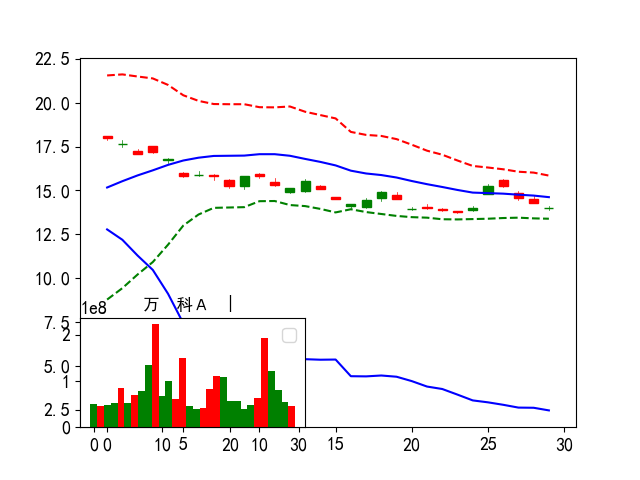

300913 2.33
xratio:0.87 ra_diff:2.33


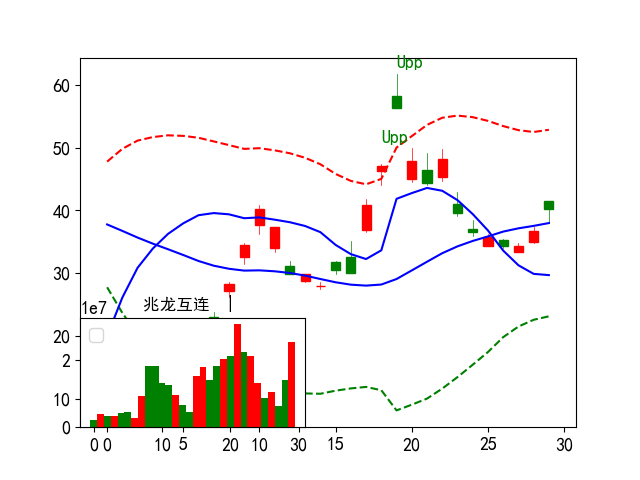

600012 1.46
xratio:0.1 ra_diff:1.46


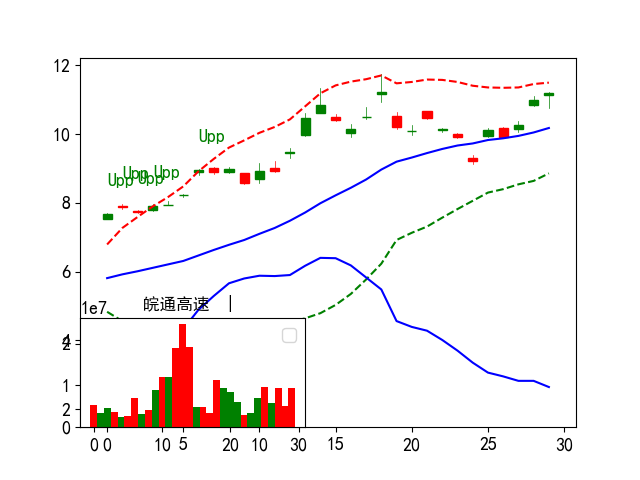

300840 1.42
xratio:0.11 ra_diff:1.42


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


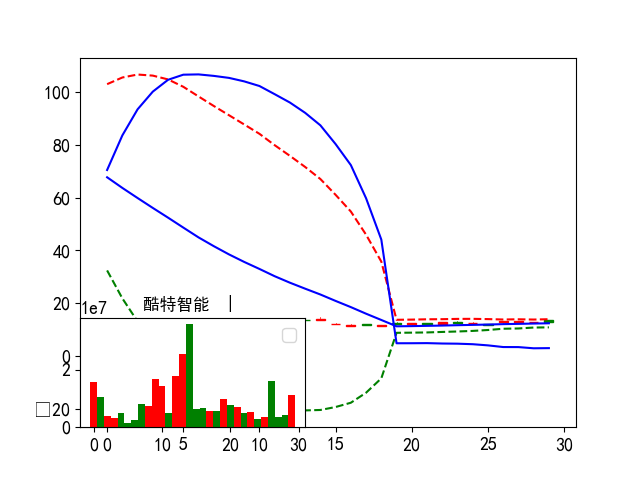

301013 1.37
xratio:0.06 ra_diff:1.37


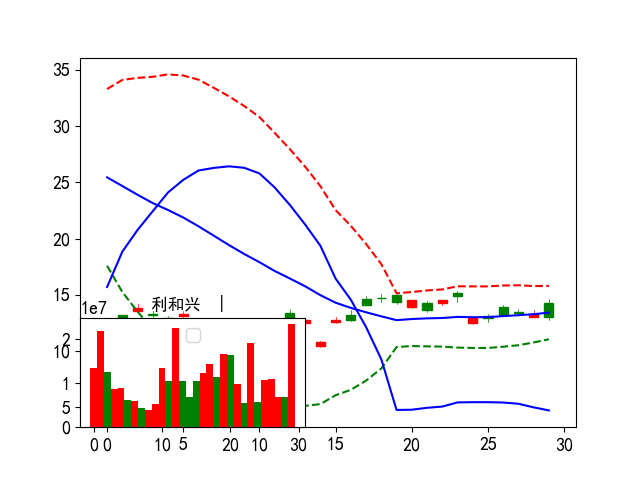

601000 1.37
xratio:0.03 ra_diff:1.37


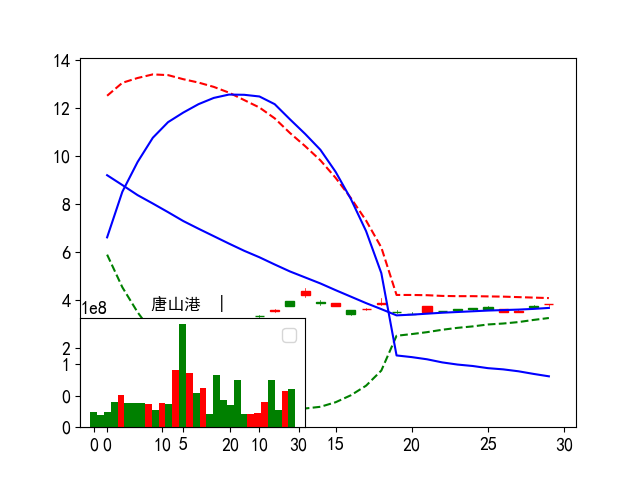

002154 1.35
xratio:0.04 ra_diff:1.35


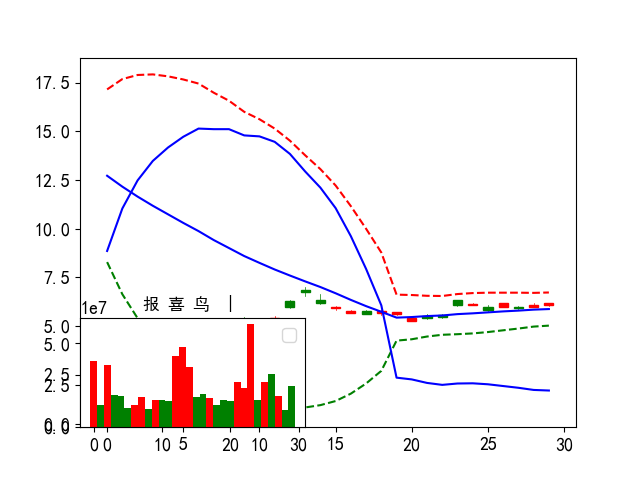

688506 1.34
xratio:0.2 ra_diff:1.34


G:\Temp\ipykernel_30360\4227828802.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


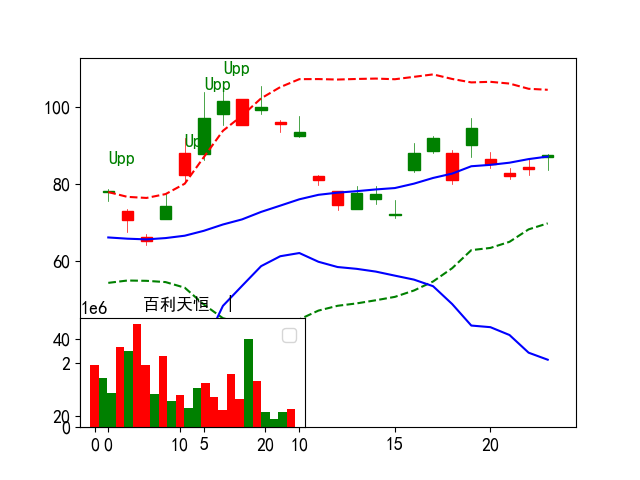

688679 1.33
xratio:0.12 ra_diff:1.33


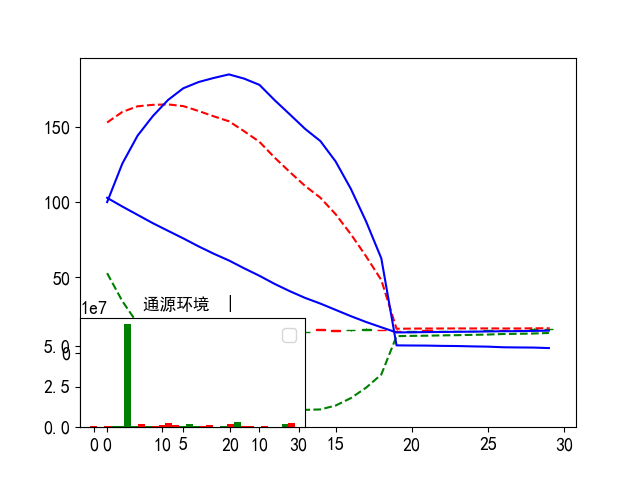

600250 1.28
xratio:0.03 ra_diff:1.28


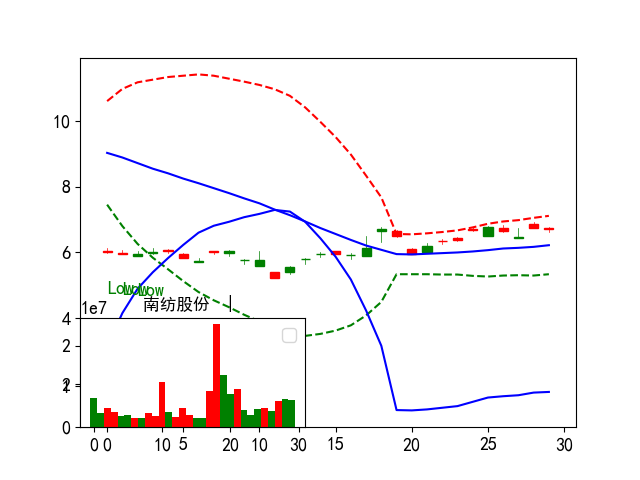

601598 1.28
xratio:0.03 ra_diff:1.28


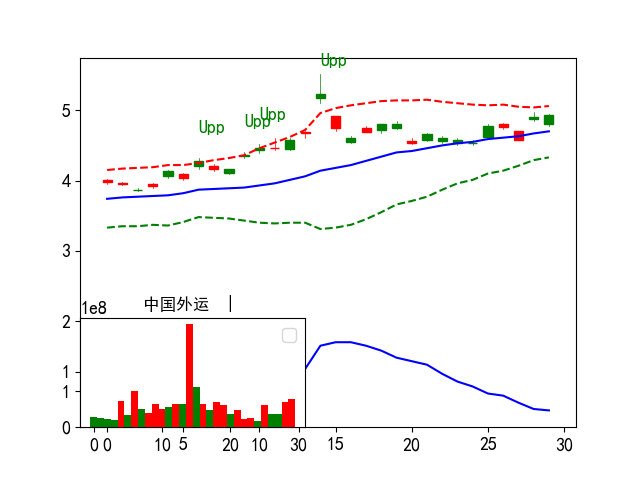

In [57]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfs.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

## 最近15天数据

In [58]:
dfs_tail9 = dfs.groupby(level=[0]).tail(15)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [59]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2023-08-11    1.02
        2023-08-18    1.00
        2023-08-25    1.00
399001  2023-08-11    1.04
        2023-08-18    1.01
        2023-08-25    1.00
399006  2023-08-11    1.05
        2023-08-18    1.02
        2023-08-25    1.00
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [60]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])[-2:]
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:15 30


ra_diff  xratio   idx   hat  close  volsum5d   hmax  lmin  perc1d  \
date                                                                            
2023-08-18     1.10   -0.03  0.60  2.83  12.55    -176.6  14.93  11.4   -1.34   
2023-08-25     1.09   -0.02  0.26  2.71  12.49    -110.1  14.93  11.4   -0.48   

             ma20  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  perc5d  
date                                                                  
2023-08-18  12.55   5.31 -43.28 -29.27 -49.40 -59.92   -4.64  -11.68  
2023-08-25  12.50   6.51   5.31 -43.28 -29.27 -49.40   -5.38   -5.74

## Run-Filter强势Upper

### filterRule test

In [61]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



9 0.04 0.32


'Bull'

0.32

date
2023-07-28   -0.03
2023-08-04   -0.04
2023-08-11   -0.05
2023-08-18   -0.06
2023-08-25   -0.06
Name: xratio, dtype: float64

xratio:-0.01 ra_diff:1.2


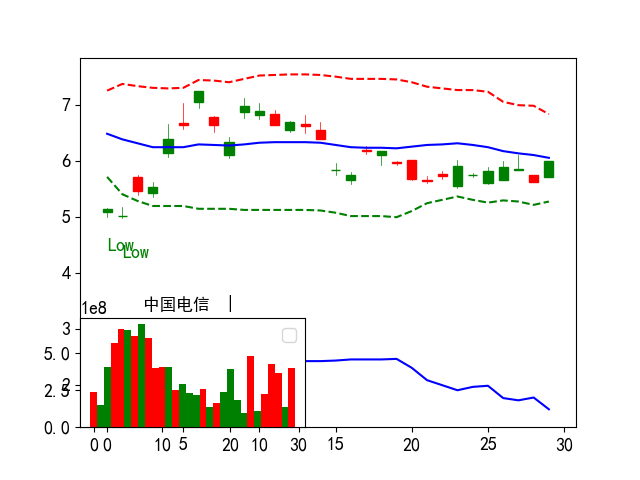

In [62]:
code_filter = '601728'


# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfs.loc[code_filter][-60:], code=code_filter)



In [63]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高

xratio:0.01 ra_diff:1.46


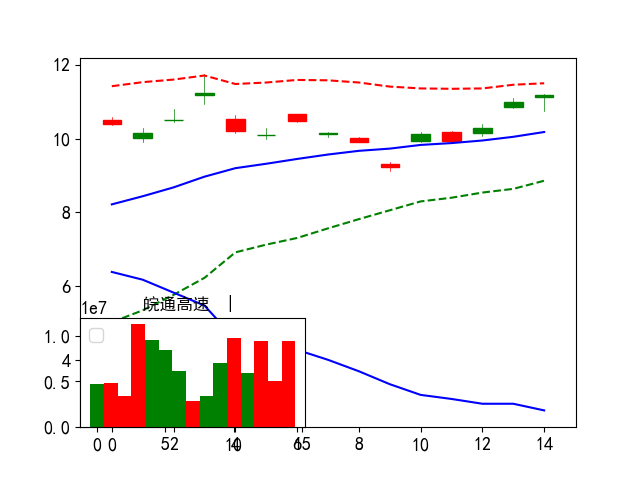

In [64]:
code='600012'
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfs_tail9.loc[code],code=code)

In [65]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)[:10]
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 002003    10
 Name: couts, dtype: int64,
 (205, 40))

Count:205 40


name  couts       date  perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
002003   伟星股份     10 2023-08-25 -0.80     1.13    0.02   0.78   1.51   9.98   
300865    大宏立      9 2023-08-25 -9.93     1.28    0.14   3.07   6.17  23.67   
300965   恒宇信通      9 2023-08-25  5.06     1.24    0.00   6.24  12.06  51.95   
301288   清研环境      9 2023-08-25 -1.88     1.66    0.24   9.83  11.29  26.55   
600671  *ST目药      9 2023-08-25 -4.96     1.36    0.05   2.62   3.82   9.96   
002485  *ST雪发      9 2023-08-25 -1.18     1.58    0.05   0.87   1.47   5.02   
600114   东睦股份      9 2023-08-25  5.59     1.35   -0.02   2.36   2.49   9.64   
601136   首创证券      9 2023-08-25  9.09     2.32    0.42  15.34  19.68  30.12   
603985   恒润股份      9 2023-08-25  3.84     1.37    0.12   5.98   7.50  26.20   
001234    泰慕士      9 2023-08-25 -2.58     1.81    0.60  17.24  25.19  38.49   

        volsum5d  ...   ma20     nclose   llow   vol1d   vol2d   vol3d  \
code              ...                                                    
002003     358.8  ...   9.41  10.031667   9.93  -42.09  212.60  -84.95   
300865     855.1  ...  20.95  23.320763  22.66  108.67  379.96  -21.91   
300965     780.9  ...  46.72  51.806375  49.60   87.34  784.05  -69.44   
301288     765.7  ...  18.41  25.909963  24.35   38.42   18.44   92.97   
600671     386.3  ...   8.31  10.037337   9.96  284.17  -40.78   13.86   
002485     376.5  ...   4.17   4.975377   4.89   16.97  294.74  -56.01   
600114     359.8  ...   7.98   9.418277   9.01   46.59   64.96  318.70   
601136     357.0  ...  16.53  29.273407  26.50   29.61  -10.67   34.63   
603985     179.9  ...  21.55  26.030526  25.28   19.68  156.21  -21.33   
001234      46.1  ...  26.29  38.977623  38.05   87.25  -10.37  -55.08   

         vol4d   vol5d  perc3d  perc5d  
code                                    
002003  267.74    5.50    1.94    3.63  
300865  -78.25  466.67   14.85    7.69  
300965  -24.83    3.81   13.83   11.24  
301288  -54.97  670.87   36.64   51.37  
600671  177.24  -48.20    4.51   15.01  
002485   71.54   49.21   13.32   15.67  
600114  -39.08  -31.41   19.75   20.65  
601136  -14.11  317.59   36.35  102.15  
603985  -39.61   64.95   12.69   18.07  
001234  -15.21   39.51    4.85   46.68  

[10 rows x 23 columns]

#### hmax Top upper > 1

In [66]:
# dfs_tail9.loc['600103']

In [67]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['volsum5d', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])

show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1)] )[:10]

count dd.couts
compute percent
code
000995    1
Name: couts, dtype: int64 (48, 40)


(code
 000995    1
 Name: couts, dtype: int64,
 (48, 40))

Count:36 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
001299  美能能源      4 2023-08-25  -3.31     1.42    0.09   6.07   6.72  21.34   
301137  哈焊华通      4 2023-08-25   3.82     1.56    0.14   4.92   8.41  22.30   
300380  安硕信息      4 2023-08-25  10.13     2.26    0.40  17.96  21.58  37.50   
600621  华鑫股份      2 2023-08-25   0.23     1.25    0.03   2.68   3.43  13.28   
605069  正和生态      2 2023-08-25   9.99     1.51    0.03   4.22   3.53  12.55   
601022  宁波远洋      2 2023-08-25  -1.85     1.19   -0.05   1.92   2.13  12.18   
300865   大宏立      3 2023-08-25  -9.93     1.28    0.14   3.07   6.17  23.67   
301288  清研环境      3 2023-08-25  -1.88     1.66    0.24   9.83  11.29  26.55   
600292  远达环保      3 2023-08-25  -6.89     1.23    0.02   1.12   1.17   6.76   
000826  启迪环境      2 2023-08-25   9.98     1.86    0.01   2.34   2.13   5.07   

        volsum5d  ...   ma20     nclose   llow   vol1d    vol2d    vol3d  \
code              ...                                                      
001299    1973.0  ...  16.67  21.853496  20.80   72.26   -31.87  1935.63   
301137    1922.1  ...  16.56  22.111828  20.63   11.33  1870.14   -39.28   
300380    1336.2  ...  21.07  36.501661  33.55   36.85   -13.25    69.46   
600621    1203.4  ...  11.42  13.027463  12.68  129.72   -22.71   -64.56   
605069    1178.0  ...   9.32  12.012213  11.30  369.83   354.55   -45.70   
601022     862.2  ...  10.80  11.909668  11.51  -16.93   845.96    91.11   
300865     855.1  ...  20.95  23.320763  22.66  108.67   379.96   -21.91   
301288     765.7  ...  18.41  25.909963  24.35   38.42    18.44    92.97   
600292     667.1  ...   5.93   6.798015   6.53   98.36   458.30   136.00   
000826     660.3  ...   3.22   4.928246   4.70  116.50   461.33    15.26   

         vol4d    vol5d  perc3d  perc5d  
code                                     
001299    7.75   -10.74   32.88   32.46  
301137  -61.07   140.93   48.57   42.49  
300380   23.29  1219.81   58.09  115.64  
600621  300.93   860.01   -0.23   22.51  
605069  -65.08   564.41   36.71   36.71  
601022  -26.97   -31.01   14.91   14.15  
300865  -78.25   466.67   14.85    7.69  
301288  -54.97   670.87   36.64   51.37  
600292  -10.20   -15.33   11.92   12.48  
000826  -55.37   122.58   56.00   67.88  

[10 rows x 23 columns]

In [68]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [69]:
show_tdx_data(
    df_mask_hmax.sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')[:20]

Count:48 40


name  couts       date   perc  ra_diff  ra_diff  xratio    idx  \
code                                                                      
301218   华是科技      5 2023-08-25   2.45     2.96     2.96    0.92  36.70   
601136   首创证券      5 2023-08-25   9.09     2.32     2.32    0.42  15.34   
300380   安硕信息      4 2023-08-25  10.13     2.26     2.26    0.40  17.96   
301316   慧博云通      2 2023-08-25  19.99     1.99     1.99    0.21  15.89   
600602   云赛智联      3 2023-08-25   9.98     1.87     1.87    0.20   1.27   
000826   启迪环境      2 2023-08-25   9.98     1.86     1.86    0.01   2.34   
001234    泰慕士      6 2023-08-25  -2.58     1.81     1.81    0.60  17.24   
301299   卓创资讯      4 2023-08-25  19.99     1.76     1.76    0.71  19.02   
301159   三维天地      2 2023-08-25  19.99     1.76     1.76    0.39  15.47   
603220   中贝通信      5 2023-08-25  10.00     1.75     1.75    0.24   5.47   
002316   亚联发展      3 2023-08-25   3.77     1.75     1.75    0.08   1.63   
301380    挖金客      2 2023-08-25  20.00     1.72     1.72    0.15  18.37   
301213   观想科技      2 2023-08-25  11.42     1.71     1.71    0.39  20.53   
000010   美丽生态      1 2023-08-25   0.57     1.69     1.69    0.00   1.43   
301288   清研环境      3 2023-08-25  -1.88     1.66     1.66    0.24   9.83   
002485  *ST雪发      2 2023-08-25  -1.18     1.58     1.58    0.05   0.87   
301137   哈焊华通      4 2023-08-25   3.82     1.56     1.56    0.14   4.92   
301049   超越科技      3 2023-08-25  -2.79     1.55     1.55    0.21   7.58   
301004   嘉益股份      3 2023-08-25   3.15     1.52     1.52    0.47   6.57   
605069   正和生态      2 2023-08-25   9.99     1.51     1.51    0.03   4.22   

          hat  close  ...   ma20     nclose   llow   vol1d    vol2d   vol3d  \
code                  ...                                                     
301218  41.41  60.10  ...  28.36  58.745222  57.35   10.64    47.18   -5.98   
601136  19.68  30.12  ...  16.53  29.273407  26.50   29.61   -10.67   34.63   
300380  21.58  37.50  ...  21.07  36.501661  33.55   36.85   -13.25   69.46   
301316  21.60  43.22  ...  26.49  41.098523  36.58   18.29    17.83  -33.56   
600602  10.02  17.08  ...  12.54  16.848864  15.68   15.24   211.62  -35.79   
000826   2.13   5.07  ...   3.22   4.928246   4.70  116.50   461.33   15.26   
001234  25.19  38.49  ...  26.29  38.977623  38.05   87.25   -10.37  -55.08   
301299  37.28  84.14  ...  59.47  84.140000  75.06  -10.51    -8.87  -18.96   
301159  22.75  56.90  ...  39.72  56.900000  54.75  -50.14    81.98   51.49   
603220   7.60  20.90  ...  15.51  20.900000  19.75  -48.95   538.67  -65.81   
002316   2.40   6.05  ...   4.97   5.953633   5.70  313.78   -11.23  -64.93   
301380  24.32  70.67  ...  49.76  68.685591  59.13   15.37   217.88   25.10   
301213  24.43  62.74  ...  44.12  63.577500  54.50   -9.66   572.44  104.80   
000010   1.37   3.50  ...   2.53   3.354593   3.13   54.26   302.99  -50.53   
301288  11.29  26.55  ...  18.41  25.909963  24.35   38.42    18.44   92.97   
002485   1.47   5.02  ...   4.17   4.975377   4.89   16.97   294.74  -56.01   
301137   8.41  22.30  ...  16.56  22.111828  20.63   11.33  1870.14  -39.28   
301049   9.85  29.28  ...  22.24  28.677770  27.15  113.34   275.28  -38.06   
301004  15.95  42.22  ...  34.81  41.975476  41.20  -28.20   347.59    3.74   
605069   3.53  12.55  ...   9.32  12.012213  11.30  369.83   354.55  -45.70   

         vol4d    vol5d  perc3d  perc5d  
code                                     
301218   15.34   -29.92   88.22   76.71  
601136  -14.11   317.59   36.35  102.15  
300380   23.29  1219.81   58.09  115.64  
301316  228.61   347.87   29.79   99.08  
600602   17.46     6.16   26.99   27.27  
000826  -55.37   122.58   56.00   67.88  
001234  -15.21    39.51    4.85   46.68  
301299  146.33   114.17   14.01   60.08  
301159  179.08   -12.00   41.54   47.26  
603220   55.84   -55.15   21.09   23.30  
002316   -8.45   -43.19    2.89    4.13  
301380   -3.82   254.32   51.78   63.47  
301213  -61.04     2.26   46.97

xratio:0.25 ra_diff:1.23


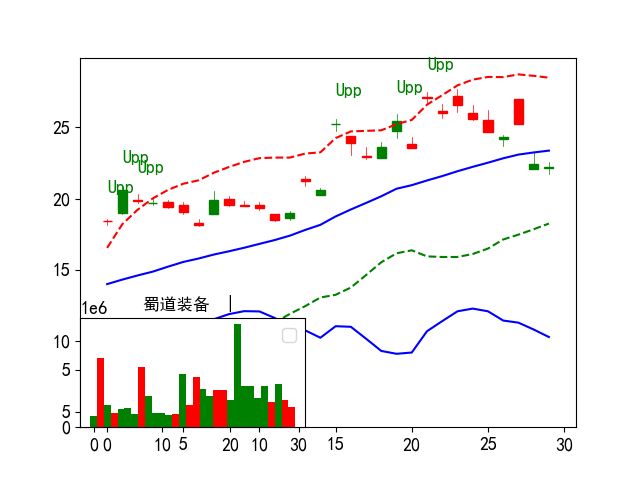

In [70]:
show_ohlc_upper(dfs.loc['300540'][-60:],code='300540')

### df_mask250 upper xratio

In [71]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))

show_tdx_data(df_mask250[df_mask250.couts > 1])
# show_tdx_data(df_mask250.loc[code_t])

(1014, 30)

count dd.couts
(code    date      
601136  2023-07-28    5
        2023-08-04    5
        2023-08-11    5
Name: couts, dtype: int64, (374, 31))
compute percent
df_mask250:287 df_mask_hmax:48
cross_hamx:36
Count:59 40


name  couts       date   perc  ra_diff  xratio     idx     hat  \
code                                                                      
600519   贵州茅台      2 2023-08-04  -0.17     1.14    0.33  227.28  265.00   
301398   星源卓镁      3 2023-08-04  -1.20     2.66    1.24   45.38   57.66   
301218   华是科技      4 2023-08-25   2.45     2.96    0.92   36.70   41.41   
300803    指南针      2 2023-08-11   4.45     1.57    0.30   23.01   28.69   
300380   安硕信息      4 2023-08-25  10.13     2.26    0.40   17.96   21.58   
001234    泰慕士      3 2023-08-18  -2.58     1.80    0.48   16.73   22.54   
603383   顶点软件      3 2023-08-11   3.37     1.51    0.56   16.26   22.90   
601136   首创证券      5 2023-08-25   9.09     2.32    0.42   15.34   19.68   
603179   新泉股份      3 2023-08-11   0.14     1.45    0.50   13.17   17.24   
603198   迎驾贡酒      2 2023-08-25   1.30     1.29    0.30   11.52   19.18   
301288   清研环境      2 2023-08-25  -1.88     1.66    0.24    9.83   11.29   
300917   特发服务      2 2023-08-04   3.49     1.54    0.18    8.39   11.80   
301049   超越科技      2 2023-08-25  -2.79     1.55    0.21    7.58    9.85   
600272   开开实业      2 2023-08-18  -9.98     1.90    0.07    7.39    6.74   
603087   甘李药业      2 2023-07-28   1.01     1.26    0.15    6.23    9.16   
001299   美能能源      2 2023-08-25  -3.31     1.42    0.09    6.07    6.72   
301148   嘉戎技术      2 2023-08-25   8.21     1.29    0.08    6.02    6.08   
603985   恒润股份      3 2023-08-25   3.84     1.37    0.12    5.98    7.50   
300899   上海凯鑫      3 2023-08-25   1.01     1.32    0.19    5.59    6.68   
300583   赛托生物      2 2023-08-04  -0.40     1.33    0.13    5.49    6.74   
603220   中贝通信      2 2023-08-25  10.00     1.75    0.24    5.47    7.60   
600660   福耀玻璃      2 2023-08-04   0.50     1.16    0.05    5.17    6.04   
000752  *ST西发      3 2023-08-18  -5.00     2.46    0.12    4.98    5.84   
600030   中信证券      2 2023-08-04   1.22     1.25    0.05    4.52    4.94   
000014   沙河股份      3 2023-08-04   0.52     1.58    0.18    4.26    6.33   
002719    麦趣尔      2 2023-08-11  -4.21     1.46   -0.03    3.60    4.87   
002945   华林证券      2 2023-08-18   5.16     1.27    0.03    3.15    3.88   
600671  *ST目药      2 2023-08-11  -4.96     1.41   -0.00    2.91    3.09   
300854   中兰环保      2 2023-08-25  -7.54     1.18    0.05    2.76    3.26   
600621   华鑫股份      2 2023-08-25   0.23     1.25    0.03    2.68    3.43   
301037    保立佳      2 2023-08-18  -0.81     1.23    0.05    2.51    4.11   
601788  XD光大证      2 2023-08-04   1.30     1.23    0.09    2.45    3.82   
603949   雪龙集团      2 2023-08-25   0.06     1.26    0.03    2.42    3.88   
000700   模塑科技      2 2023-08-11   1.83     1.47    0.05    2.26    2.72   
601099    太平洋      3 2023-08-11   1.95     1.86    0.05    2.18    2.75   
002221   东华能源      3 2023-08-25  -0.65     1.30    0.04    2.02    2.47   
605318    法狮龙      3 2023-08-11   8.32     1.22    0.03    1.99    2.92   
601022   宁波远洋      2 2023-08-25  -1.85     1.19   -0.05    1.92    2.13   
600690   海尔智家      2 2023-08-04   0.93     1.11   -0.03    1.86    2.66   
603506   南都物业      2 2023-08-04   2.15     1.21   -0.01    1.77    2.39   
600104   上汽集团      2 2023-08-04   0.50     1.16   -0.00    1.69    1.94   
000609   中迪投资      2 2023-08-04   1.08     1.53   -0.00    1.66    1.98   
000589   贵州轮胎      3 2023-08-04   0.74     1.36    0.05    1.65    2.37   
605196   华通线缆      3 2023-08-11   1.13     1.22    0.02    1.44    1.88   
600791   京能置业      2 2023-08-04  -0.20     1.38    0.02    1.36    1.56   
002146   荣盛发展      2 2023-08-04  -0.41     2.49    0.00    1.33    1.66   
000514  渝 开 发      2 2023-08-04   1.76     1.39   -0.00    1.33    1.31   
002898   赛隆药业      2 2023-08-18  -3.34     1.16    0.03    1.32    1.75   
600675   中华企业      2 2023-08-04   1.03     1.54    0.02    1.26    1.35   
601606   长城军工      2 2023-08-25   0.75     1.22    0.04    1.25    2.37   
000926   福星股份      2 2023-08-04  -0.21     1.32    0.02    1.19    1.37   
600322   天房发展      3 2023-08-18  1

df_mask250:59
600519 1.07
xratio:0.01 ra_diff:1.07


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


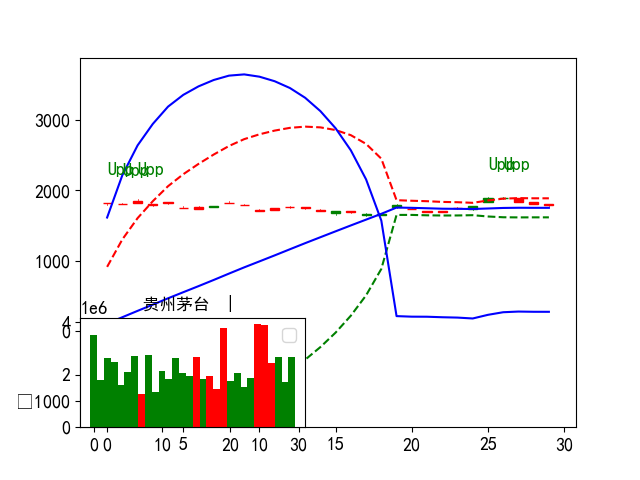

301398 2.18
xratio:1.22 ra_diff:2.18


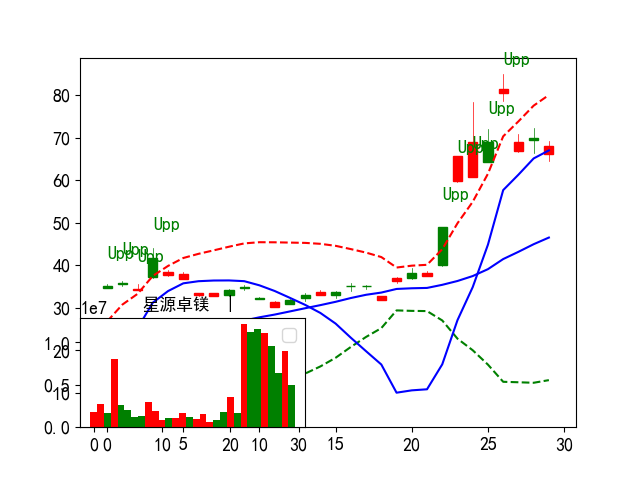

301218 2.96
xratio:0.59 ra_diff:2.96


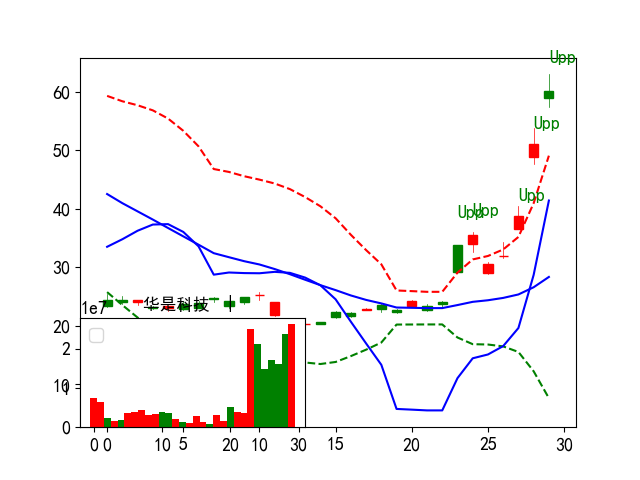

300803 1.51
xratio:0.35 ra_diff:1.51


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


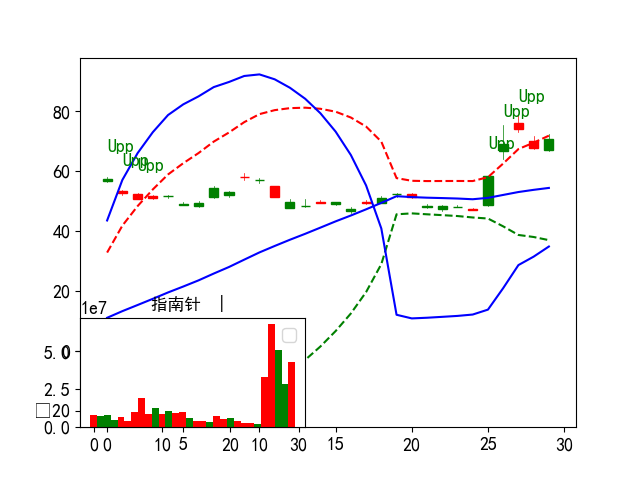

300380 2.26
xratio:0.29 ra_diff:2.26


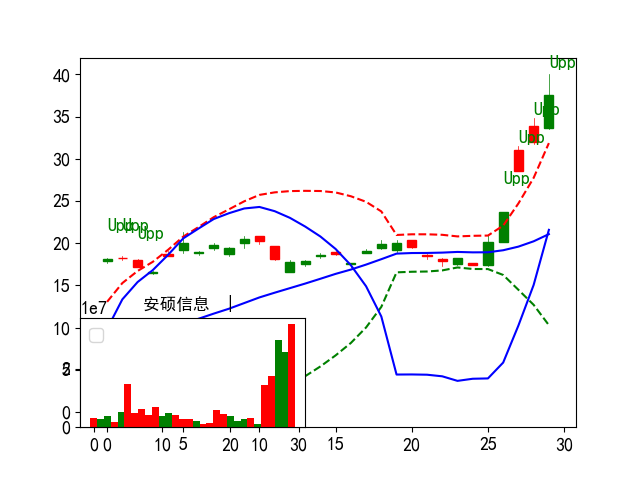

001234 1.81
xratio:0.33 ra_diff:1.81


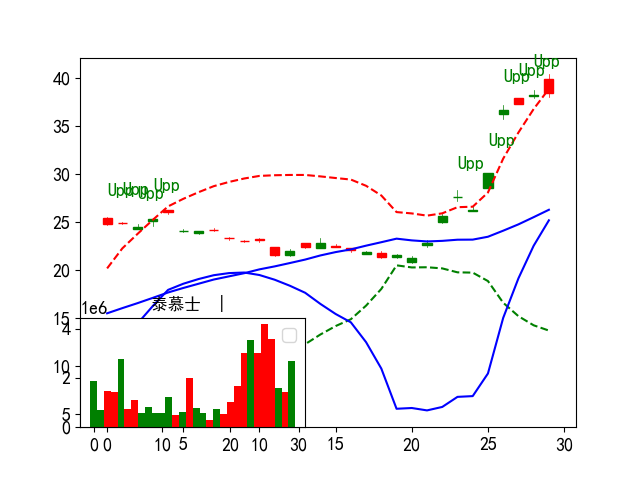

603383 1.38
xratio:0.54 ra_diff:1.38


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


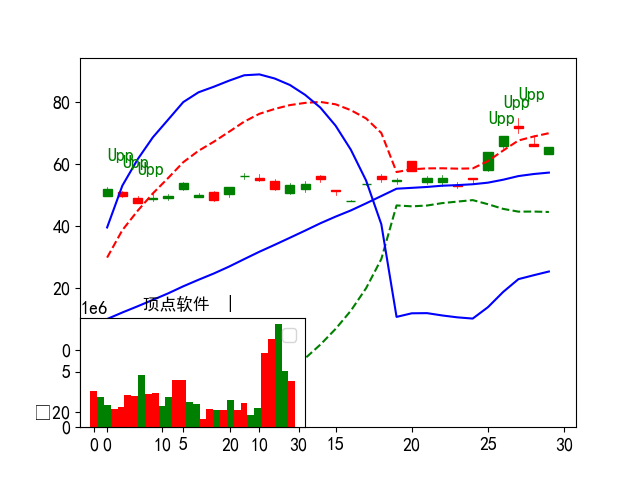

601136 2.32
xratio:0.19 ra_diff:2.32


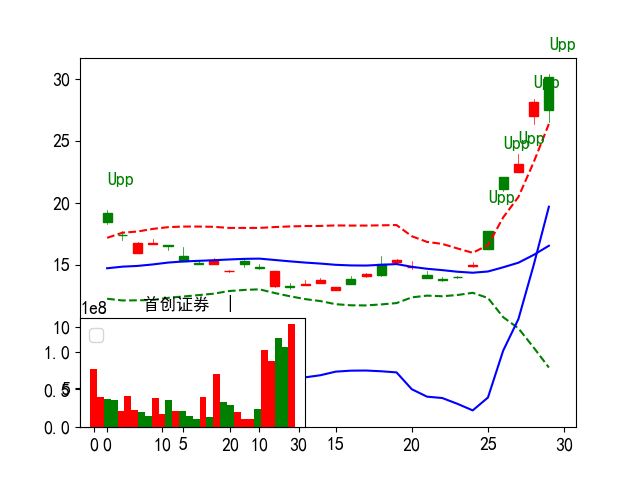

603179 1.36
xratio:0.32 ra_diff:1.36


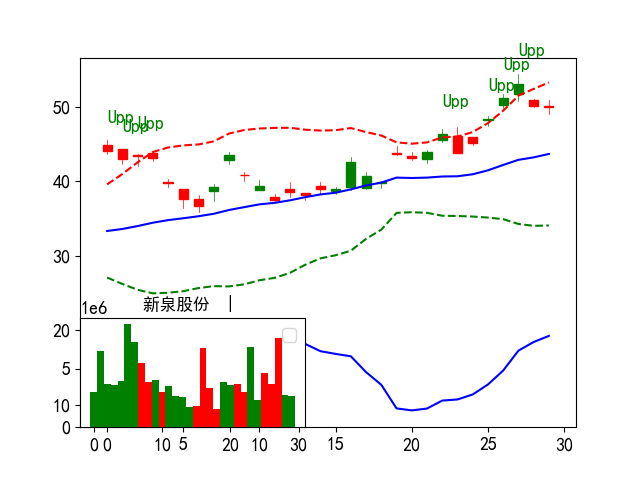

603198 1.29
xratio:-0.02 ra_diff:1.29


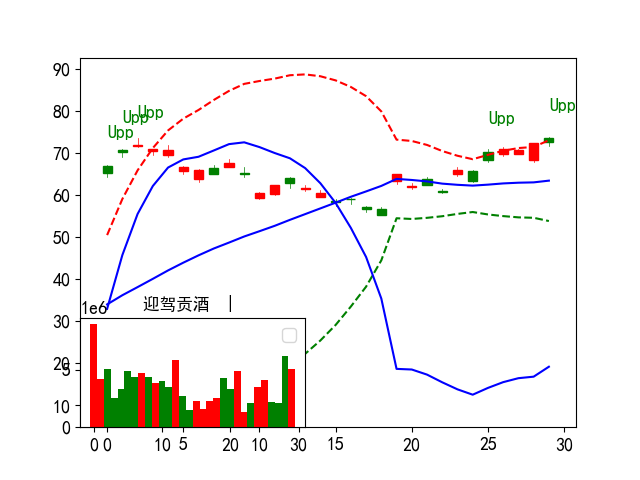

In [72]:
print("df_mask250:%s"%(len(df_mask250[df_mask250.couts > 1])))
for co in df_mask250[df_mask250.couts > 1].index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [73]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date  lopen  lhigh   llow  close         vol        amount  \
code                                                                      
301218 2023-08-25  58.94  62.95  57.35  60.10  26430943.0  1.579597e+09   
301380 2023-08-25  59.13  70.67  59.13  70.67  10683380.0  7.023211e+08   

        ra_diff    ma5   ma10  ...    idx  couts     nclose  name   open  \
code                           ...                                         
301218     2.96  41.32  34.51  ...  36.70      4  58.745222  华是科技  58.94   
301380     1.72  53.18  49.90  ...  18.37      1  68.685591   挖金客  59.13   

         high    low  llastp            ticktime   perc  
code                                                     
301218  62.95  57.35   58.66 2023-08-22 15:00:03   2.45  
301380  70.67  59.13   58.89 2023-08-22 15:00:03  20.00  

[2 rows x 40 columns]

(136, 40)

In [74]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

show_tdx_data(df_masklastd)
show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(287, 40)  lastd:(37, 40) 
Count:37 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
300380  安硕信息      4 2023-08-25  10.13     2.26    0.40  17.96  21.58  37.50   
301137  哈焊华通      1 2023-08-25   3.82     1.56    0.14   4.92   8.41  22.30   
002235  安妮股份      1 2023-08-25  10.05     1.48   -0.02   2.56   2.93   9.42   
301159  三维天地      1 2023-08-25  19.99     1.76    0.39  15.47  22.75  56.90   
301288  清研环境      2 2023-08-25  -1.88     1.66    0.24   9.83  11.29  26.55   
601136  首创证券      5 2023-08-25   9.09     2.32    0.42  15.34  19.68  30.12   
001299  美能能源      2 2023-08-25  -3.31     1.42    0.09   6.07   6.72  21.34   
003005   竞业达      1 2023-08-25  10.00     1.35   -0.21   6.06  10.31  38.83   
000010  美丽生态      1 2023-08-25   0.57     1.69    0.00   1.43   1.37   3.50   
301049  超越科技      2 2023-08-25  -2.79     1.55    0.21   7.58   9.85  29.28   
002309  ST中利      1 2023-08-25   5.00     1.28   -0.03   0.96   1.34   4.83   
603220  中贝通信      2 2023-08-25  10.00     1.75    0.24   5.47   7.60  20.90   
002310  东方园林      1 2023-08-25   3.68     1.73    0.02   1.19   1.32   2.82   
600114  东睦股份      1 2023-08-25   5.59     1.35   -0.02   2.36   2.49   9.64   
300899  上海凯鑫      3 2023-08-25   1.01     1.32    0.19   5.59   6.68  27.95   
601022  宁波远洋      2 2023-08-25  -1.85     1.19   -0.05   1.92   2.13  12.18   
301024  霍普股份      1 2023-08-25   7.80     1.56    0.37  10.53  15.14  34.70   
000995  皇台酒业      1 2023-08-25  -5.34     1.20    0.01   2.50   3.35  19.67   
002221  东华能源      3 2023-08-25  -0.65     1.30    0.04   2.02   2.47  10.62   
603985  恒润股份      3 2023-08-25   3.84     1.37    0.12   5.98   7.50  26.20   
603949  雪龙集团      2 2023-08-25   0.06     1.26    0.03   2.42   3.88  17.87   
002569  ST步森      1 2023-08-25   0.48     1.28   -0.01   1.40   1.23   6.32   
600292  远达环保      1 2023-08-25  -6.89     1.23    0.02   1.12   1.17   6.76   
002999  天禾股份      1 2023-08-25  -2.86     1.18   -0.04   1.32   1.19   8.48   
605088  冠盛股份      1 2023-08-25   9.99     1.20   -0.02   1.94   3.11  18.83   
601606  长城军工      2 2023-08-25   0.75     1.22    0.04   1.25   2.37  14.69   
002480  新筑股份      2 2023-08-25   1.54     1.19    0.00   0.81   0.84   5.28   
301148  嘉戎技术      2 2023-08-25   8.21     1.29    0.08   6.02   6.08  27.01   
300854  中兰环保      2 2023-08-25  -7.54     1.18    0.05   2.76   3.26  18.03   
301265  华新环保      1 2023-08-25  -4.66     1.12   -0.00   1.39   1.51  12.88   
603607  京华激光      1 2023-08-25   1.10     1.18    0.02   1.24   1.97  15.59   
300588  熙菱信息      1 2023-08-25   2.67     1.24    0.00   1.28   2.71  13.09   
603198  迎驾贡酒      2 2023-08-25   1.30     1.29    0.30  11.52  19.18  73.40   
301127  天源环保      1 2023-08-25  -1.49     1.11    0.00   1.07   1.02  10.56   
000786  北新建材      1 2023-08-25   3.10     1.24   -0.02   5.00   5.84  28.97   
600796  钱江生化      1 2023-08-25  -8.01     1.10    0.01   0.52   0.57   5.63   
600621  华鑫股份      2 2023-08-25   0.23     1.25    0.03   2.68   3.43  13.28   

        volsum5d  ...   ma20     nclose   llow    vol1d    vol2d    vol3d  \
code              ...                                                       
300380    1336.2  ...  21.07  36.501661  33.55    36.85   -13.25    69.46   
301137    1922.1  ...  16.56  22.111828  20.63    11.33  1870.14   -39.28   
002235     483.2  ...   6.98   8.968000   8.36    21.75   157.74   171.40   
301159     250.4  ...  39.72  56.900000  54.75   -50.14    81.98    51.49   
301288     765.7  ...  18.41  25.909963  24.35    38.42    18.44    92.97   
601136     357.0  ...  16.53  29.273407  26.50    29.61   -10.67    34.63   
001299    1973.0  ...  16.67  21.853496  20.80    72.26   -31.87  1935.63   
003005     337.2  ...  32.66  38.830000  35.51    10.56    31.94   253.29   
000010     466.4  ...   2.53   3.354593   3.13    54.26   302.99   -50.53   
301049     348.9  ...  22.24  28.677770  27.15   113.34   275.28   -38.06   
00

Count:10 40


name  couts       date  perc  ra_diff  xratio    idx    hat  close  \
code                                                                         
301148  嘉戎技术      2 2023-08-25  8.21     1.29    0.08   6.02   6.08  27.01   
300854  中兰环保      2 2023-08-25 -7.54     1.18    0.05   2.76   3.26  18.03   
301265  华新环保      1 2023-08-25 -4.66     1.12   -0.00   1.39   1.51  12.88   
603607  京华激光      1 2023-08-25  1.10     1.18    0.02   1.24   1.97  15.59   
300588  熙菱信息      1 2023-08-25  2.67     1.24    0.00   1.28   2.71  13.09   
603198  迎驾贡酒      2 2023-08-25  1.30     1.29    0.30  11.52  19.18  73.40   
301127  天源环保      1 2023-08-25 -1.49     1.11    0.00   1.07   1.02  10.56   
000786  北新建材      1 2023-08-25  3.10     1.24   -0.02   5.00   5.84  28.97   
600796  钱江生化      1 2023-08-25 -8.01     1.10    0.01   0.52   0.57   5.63   
600621  华鑫股份      2 2023-08-25  0.23     1.25    0.03   2.68   3.43  13.28   

        volsum5d  ...   ma20     nclose   llow   vol1d   vol2d  vol3d   vol4d  \
code              ...                                                           
301148     326.5  ...  22.45  25.766169  24.55  125.06   42.69 -36.79   46.77   
300854     520.8  ...  16.29  17.955057  17.39   67.36  500.10  33.49  -65.72   
301265     434.6  ...  12.05  12.709665  12.48    6.86  361.41  72.37  -69.90   
603607     290.9  ...  14.29  15.410677  15.09  113.12   34.21 -34.57  164.14   
300588     302.6  ...  11.69  12.939655  12.63   43.97  132.29 -56.27  -22.83   
603198     141.0  ...  63.37  73.080943  71.57  -17.78  190.47  -4.88  -45.79   
301127     790.3  ...  10.04  10.466719  10.35  -25.47  567.55   4.66  -80.29   
000786     281.5  ...  25.73  28.753222  28.09  195.28   -2.85  -0.50  -46.15   
600796     634.1  ...   5.34   5.618615   5.51  344.59  182.22  53.65   10.70   
600621    1203.4  ...  11.42  13.027463  12.68  129.72  -22.71 -64.56  300.93   

         vol5d  perc3d  perc5d  
code                            
301148  148.72    8.52   21.01  
300854  -14.45    8.22    6.31  
301265   63.89    7.42    6.53  
603607   14.05    6.13   10.02  
300588  205.47    5.74   18.78  
603198   18.93    5.46   11.92  
301127  323.90    5.07    3.33  
000786  135.72    4.10   13.08  
600796   42.96    3.49    4.84  
600621  860.01   -0.23   22.51  

[10 rows x 23 columns]

### df_mask_hmax 061

df_mask_hmax:48
000995 1.2
xratio:-0.03 ra_diff:1.2


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


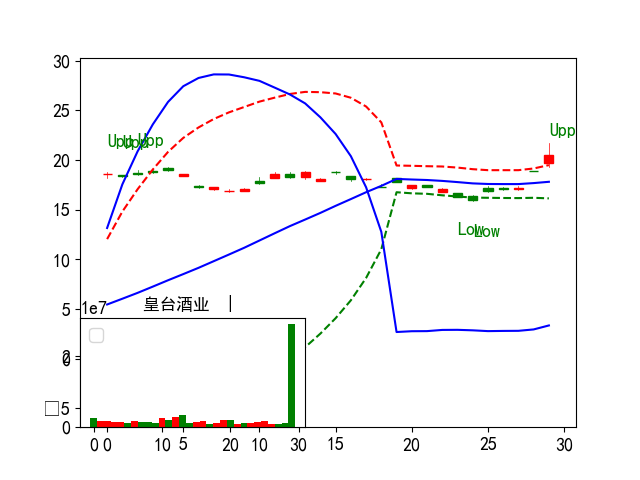

001299 1.42
xratio:-0.05 ra_diff:1.42


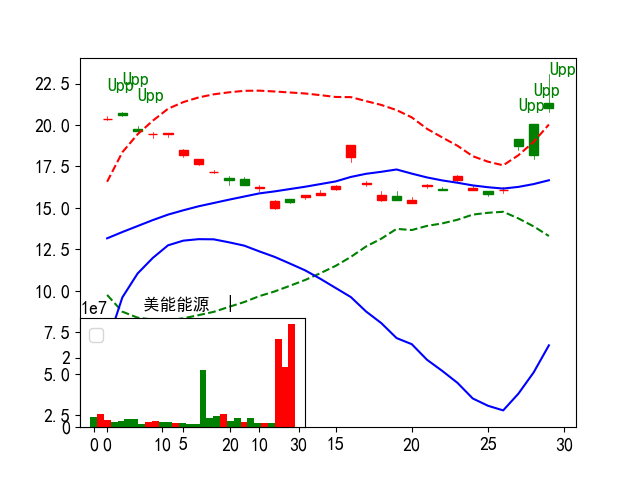

301137 1.56
xratio:0.12 ra_diff:1.56


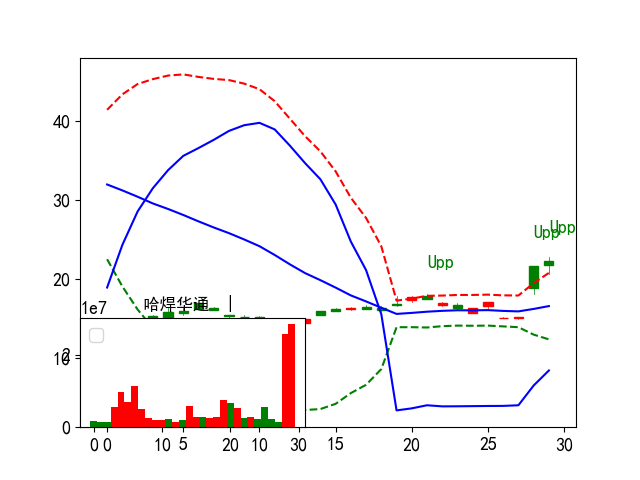

300380 2.26
xratio:0.29 ra_diff:2.26


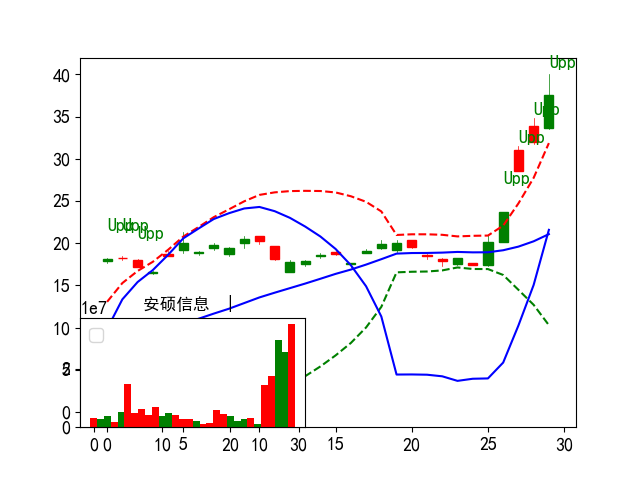

600621 1.25
xratio:-0.0 ra_diff:1.25


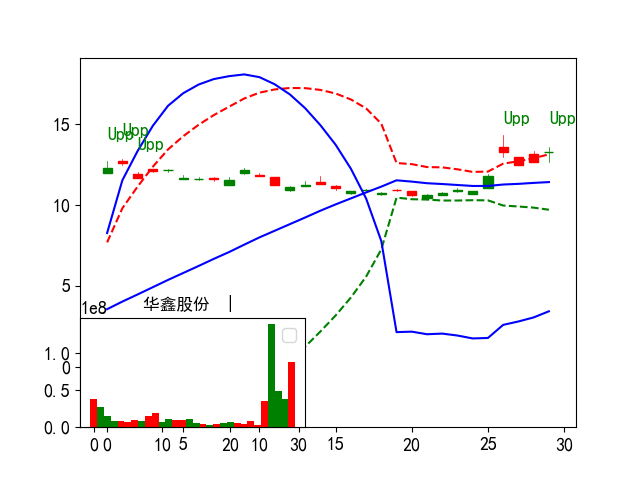

605069 1.51
xratio:-0.01 ra_diff:1.51


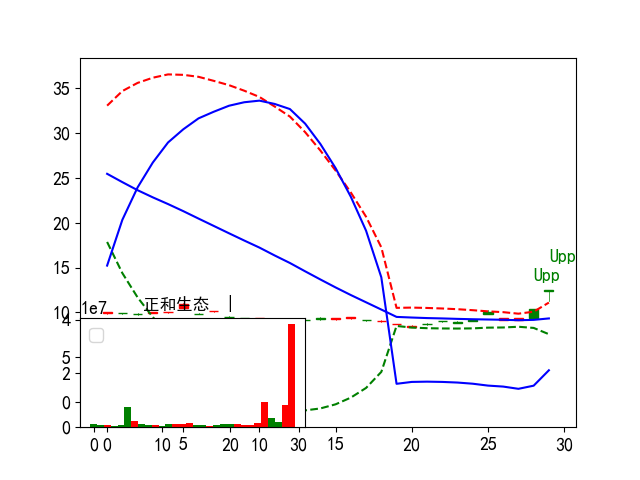

601022 1.19
xratio:-0.09 ra_diff:1.19


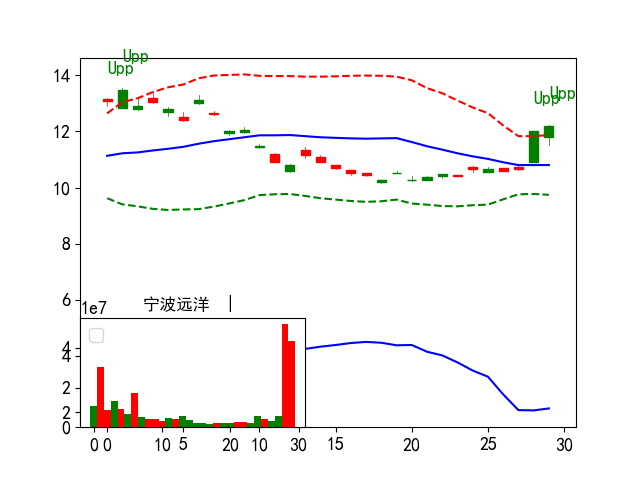

300865 1.28
xratio:0.1 ra_diff:1.28


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


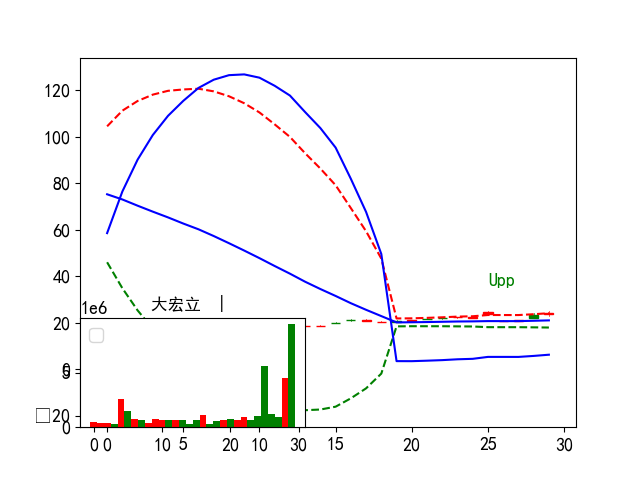

002999 1.18
xratio:-0.08 ra_diff:1.18


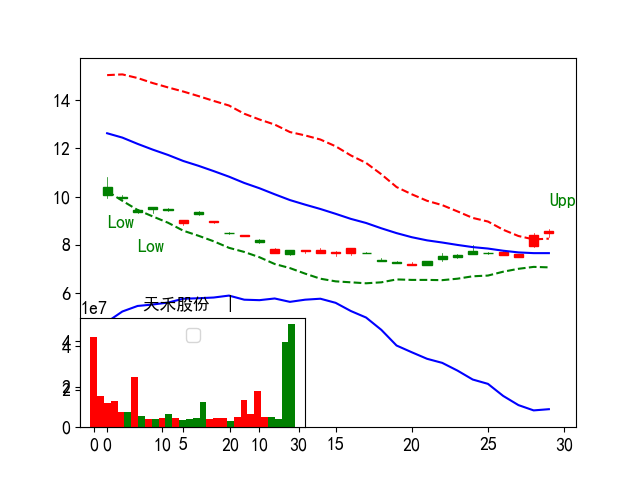

301127 1.11
xratio:-0.01 ra_diff:1.11


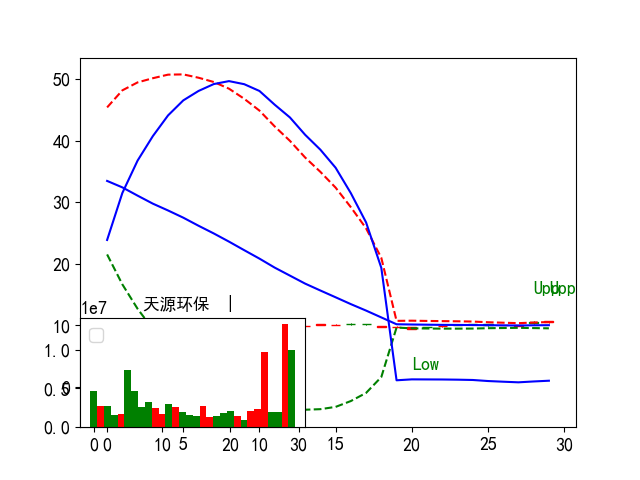

In [76]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:37
300380 2.26
xratio:0.29 ra_diff:2.26


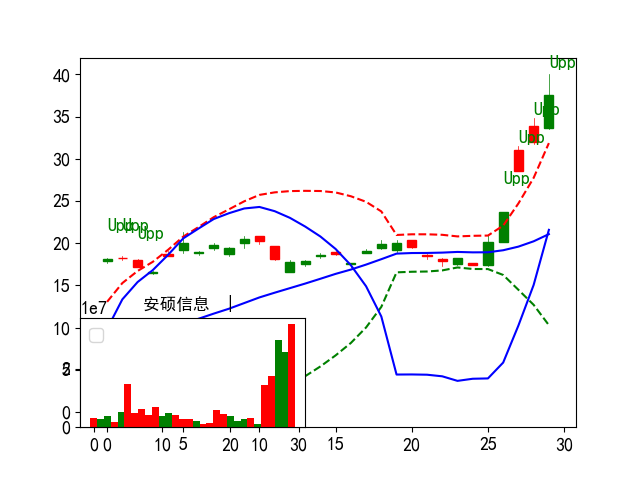

301137 1.56
xratio:0.12 ra_diff:1.56


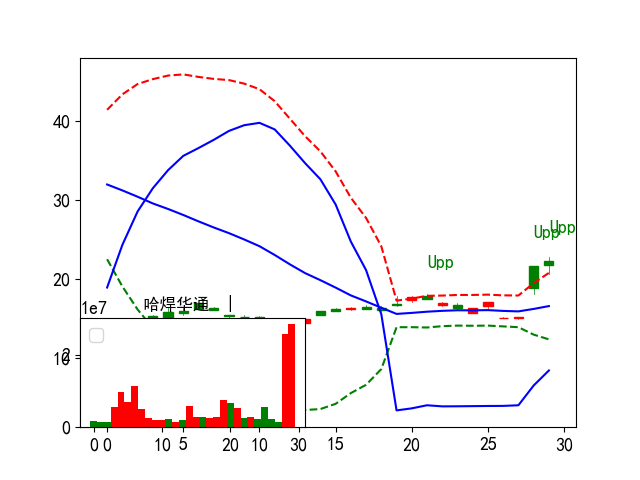

002235 1.48
xratio:-0.07 ra_diff:1.48


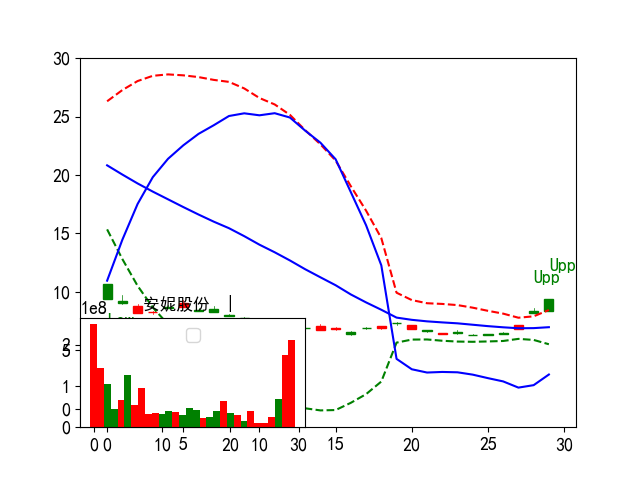

301159 1.76
xratio:0.34 ra_diff:1.76


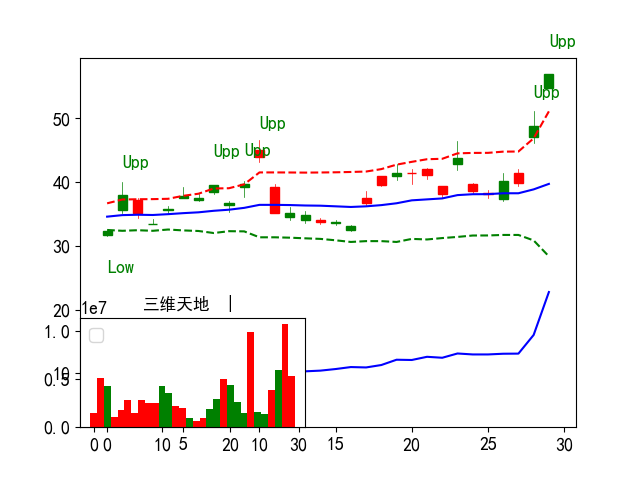

301288 1.66
xratio:0.11 ra_diff:1.66


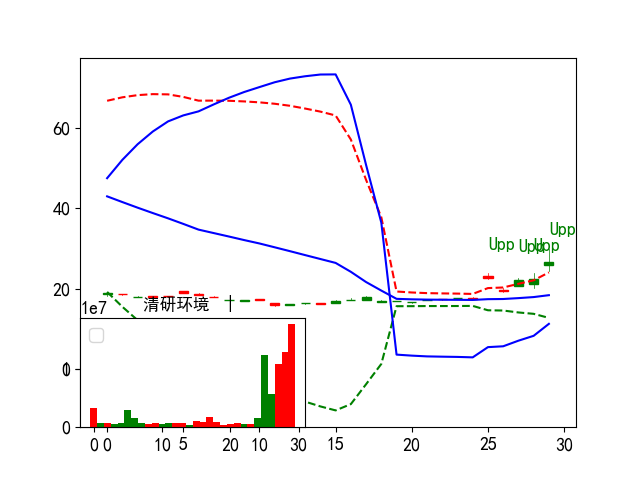

601136 2.32
xratio:0.19 ra_diff:2.32


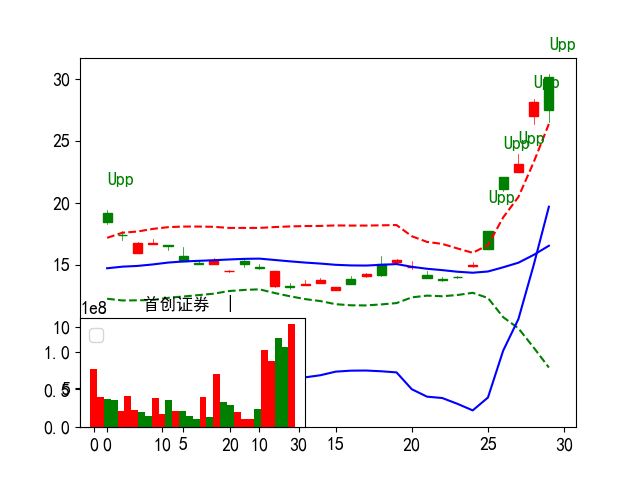

001299 1.42
xratio:-0.05 ra_diff:1.42


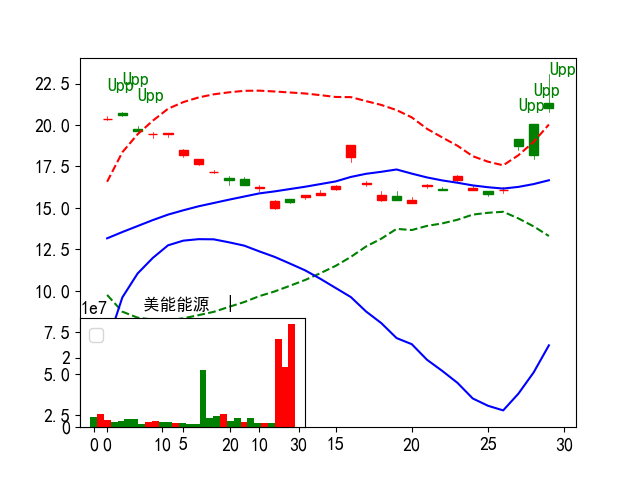

003005 1.35
xratio:-0.38 ra_diff:1.35


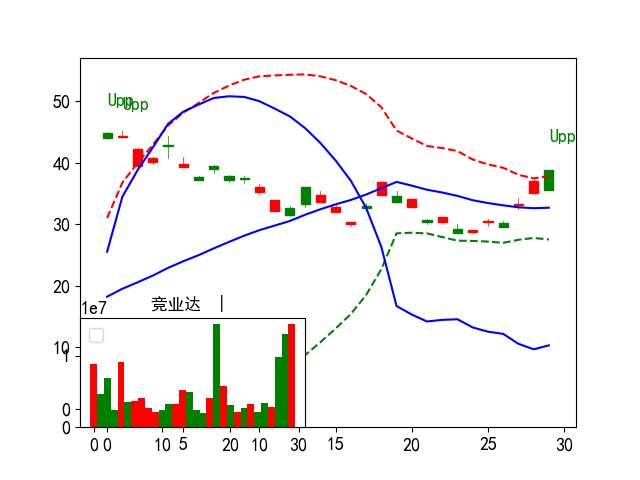

000010 1.69
xratio:-0.02 ra_diff:1.69


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


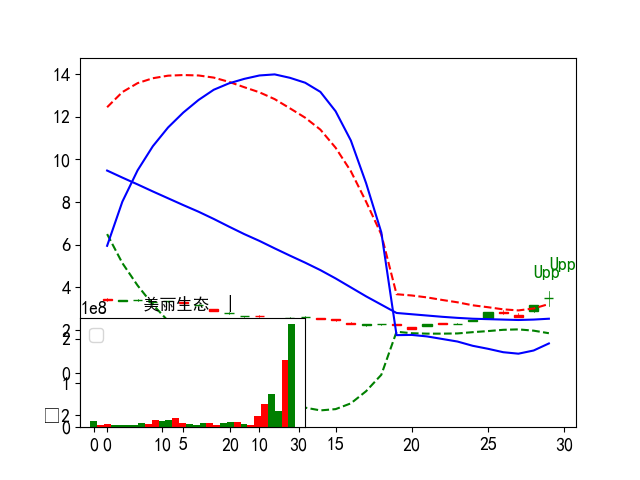

301049 1.55
xratio:0.06 ra_diff:1.55


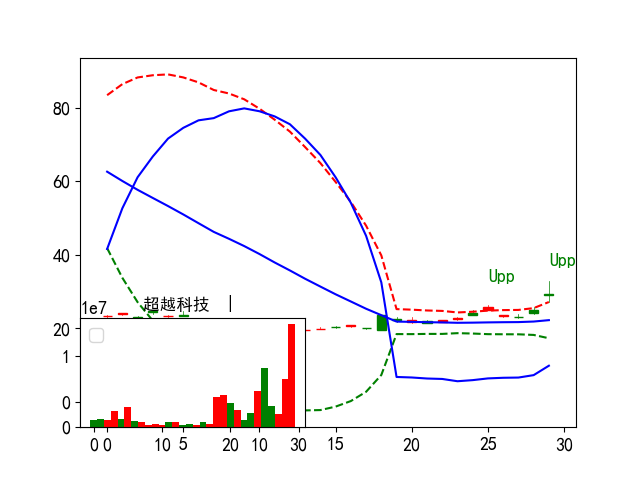

In [77]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [78]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250])

cross_hamx:28
Count:28 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
300380  安硕信息      4 2023-08-25  10.13     2.26    0.40  17.96  21.58  37.50   
301137  哈焊华通      1 2023-08-25   3.82     1.56    0.14   4.92   8.41  22.30   
002235  安妮股份      1 2023-08-25  10.05     1.48   -0.02   2.56   2.93   9.42   
301159  三维天地      1 2023-08-25  19.99     1.76    0.39  15.47  22.75  56.90   
301288  清研环境      2 2023-08-25  -1.88     1.66    0.24   9.83  11.29  26.55   
601136  首创证券      5 2023-08-25   9.09     2.32    0.42  15.34  19.68  30.12   
001299  美能能源      2 2023-08-25  -3.31     1.42    0.09   6.07   6.72  21.34   
003005   竞业达      1 2023-08-25  10.00     1.35   -0.21   6.06  10.31  38.83   
000010  美丽生态      1 2023-08-25   0.57     1.69    0.00   1.43   1.37   3.50   
301049  超越科技      2 2023-08-25  -2.79     1.55    0.21   7.58   9.85  29.28   
603220  中贝通信      2 2023-08-25  10.00     1.75    0.24   5.47   7.60  20.90   
600114  东睦股份      1 2023-08-25   5.59     1.35   -0.02   2.36   2.49   9.64   
300899  上海凯鑫      3 2023-08-25   1.01     1.32    0.19   5.59   6.68  27.95   
601022  宁波远洋      2 2023-08-25  -1.85     1.19   -0.05   1.92   2.13  12.18   
000995  皇台酒业      1 2023-08-25  -5.34     1.20    0.01   2.50   3.35  19.67   
002221  东华能源      3 2023-08-25  -0.65     1.30    0.04   2.02   2.47  10.62   
603985  恒润股份      3 2023-08-25   3.84     1.37    0.12   5.98   7.50  26.20   
603949  雪龙集团      2 2023-08-25   0.06     1.26    0.03   2.42   3.88  17.87   
002569  ST步森      1 2023-08-25   0.48     1.28   -0.01   1.40   1.23   6.32   
600292  远达环保      1 2023-08-25  -6.89     1.23    0.02   1.12   1.17   6.76   
002999  天禾股份      1 2023-08-25  -2.86     1.18   -0.04   1.32   1.19   8.48   
300854  中兰环保      2 2023-08-25  -7.54     1.18    0.05   2.76   3.26  18.03   
603607  京华激光      1 2023-08-25   1.10     1.18    0.02   1.24   1.97  15.59   
300588  熙菱信息      1 2023-08-25   2.67     1.24    0.00   1.28   2.71  13.09   
603198  迎驾贡酒      2 2023-08-25   1.30     1.29    0.30  11.52  19.18  73.40   
301127  天源环保      1 2023-08-25  -1.49     1.11    0.00   1.07   1.02  10.56   
600796  钱江生化      1 2023-08-25  -8.01     1.10    0.01   0.52   0.57   5.63   
600621  华鑫股份      2 2023-08-25   0.23     1.25    0.03   2.68   3.43  13.28   

        volsum5d  ...   ma20     nclose   llow    vol1d    vol2d    vol3d  \
code              ...                                                       
300380    1336.2  ...  21.07  36.501661  33.55    36.85   -13.25    69.46   
301137    1922.1  ...  16.56  22.111828  20.63    11.33  1870.14   -39.28   
002235     483.2  ...   6.98   8.968000   8.36    21.75   157.74   171.40   
301159     250.4  ...  39.72  56.900000  54.75   -50.14    81.98    51.49   
301288     765.7  ...  18.41  25.909963  24.35    38.42    18.44    92.97   
601136     357.0  ...  16.53  29.273407  26.50    29.61   -10.67    34.63   
001299    1973.0  ...  16.67  21.853496  20.80    72.26   -31.87  1935.63   
003005     337.2  ...  32.66  38.830000  35.51    10.56    31.94   253.29   
000010     466.4  ...   2.53   3.354593   3.13    54.26   302.99   -50.53   
301049     348.9  ...  22.24  28.677770  27.15   113.34   275.28   -38.06   
603220     424.6  ...  15.51  20.900000  19.75   -48.95   538.67   -65.81   
600114     359.8  ...   7.98   9.418277   9.01    46.59    64.96   318.70   
300899     580.0  ...  24.10  27.431719  26.52    65.94   168.51   -13.66   
601022     862.2  ...  10.80  11.909668  11.51   -16.93   845.96    91.11   
000995    2206.5  ...  17.81  20.020485  19.33  2178.75    61.62    -4.55   
002221     266.6  ...   9.01  10.617901  10.49   -49.73    16.48   225.54   
603985     179.9  ...  21.55  26.030526  25.28    19.68   156.21   -21.33   
603949     307.5  ...  15.73  17.672791  17.45   -40.02    57.16   325.35   
002569     525.4  ...   5.49   6.306776   6.23   118.04   287.43   124.52   
600292     667.1  ..

df_mask250:28
002569 1.28
xratio:-0.03 ra_diff:1.28


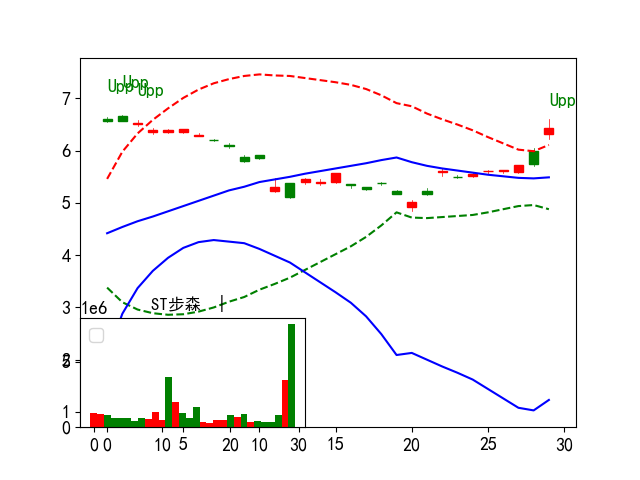

600292 1.23
xratio:0.01 ra_diff:1.23


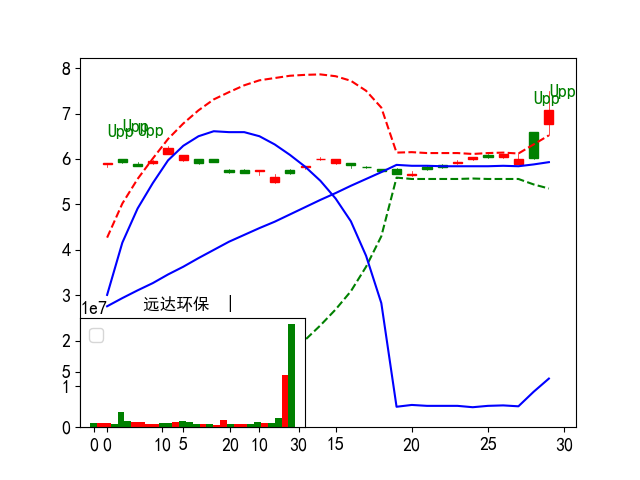

002999 1.18
xratio:-0.08 ra_diff:1.18


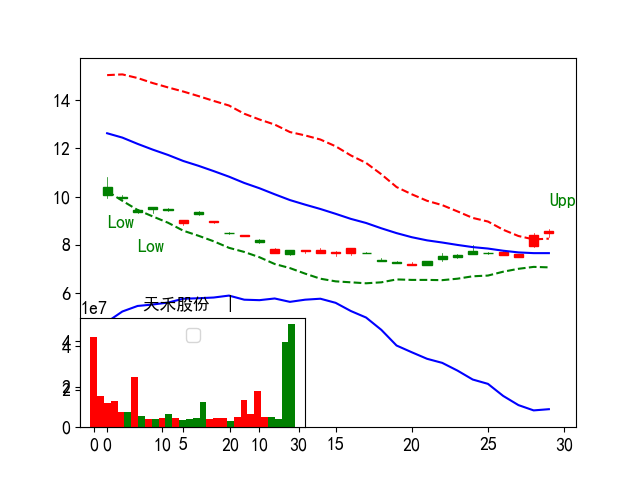

300854 1.18
xratio:0.0 ra_diff:1.18


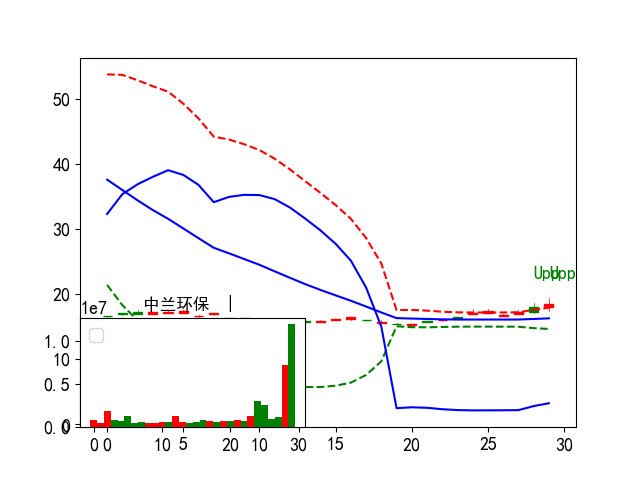

603607 1.18
xratio:-0.01 ra_diff:1.18


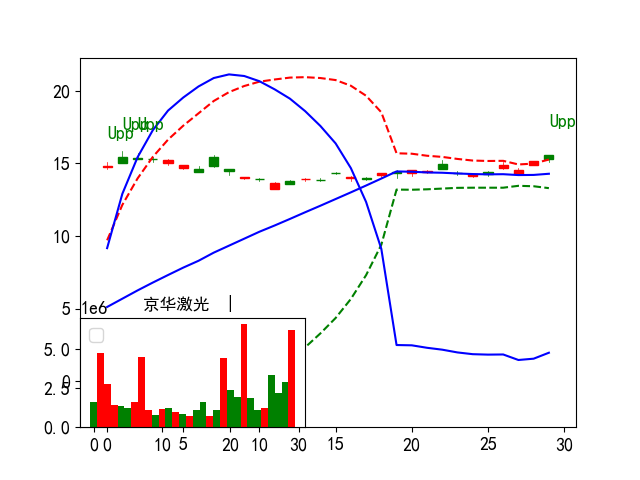

300588 1.24
xratio:0.02 ra_diff:1.24


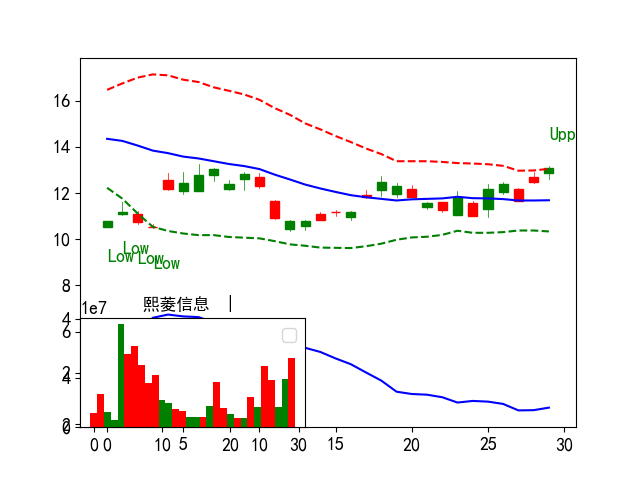

603198 1.29
xratio:-0.02 ra_diff:1.29


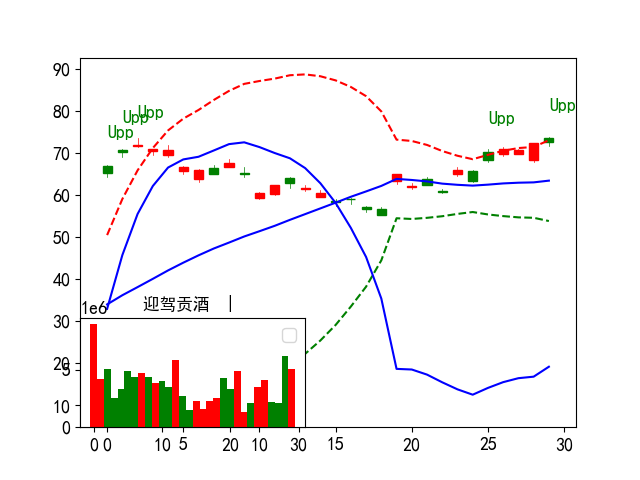

301127 1.11
xratio:-0.01 ra_diff:1.11


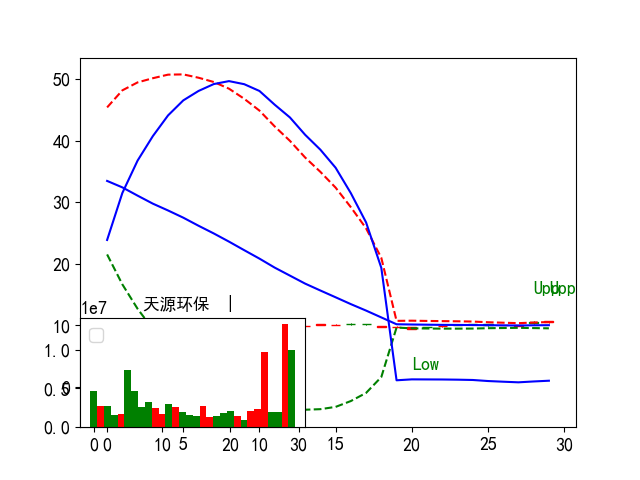

600796 1.1
xratio:-0.01 ra_diff:1.1


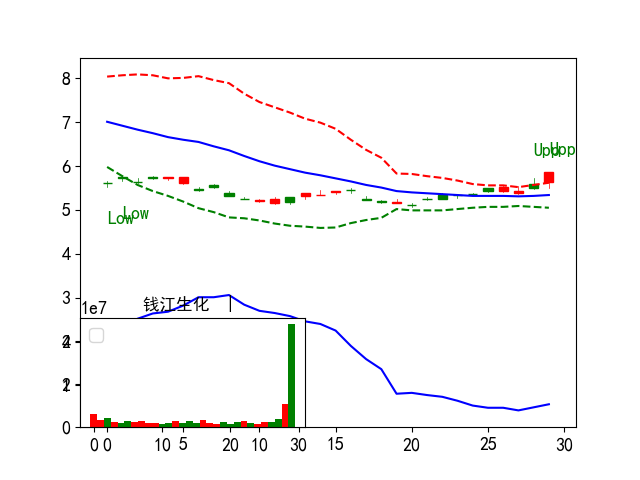

600621 1.25
xratio:-0.0 ra_diff:1.25


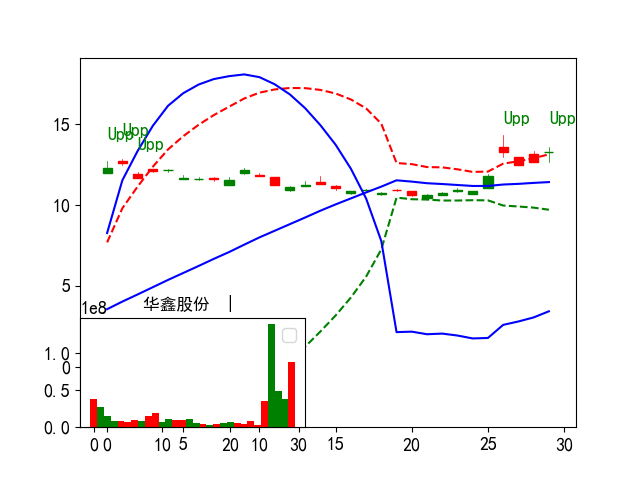

In [79]:
print("df_mask250:%s"%(len(cross_hmax_250)))
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

## 写入061

In [80]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

write blk [Y] or [N]:y
Rewrite code [Y] or append [N](defalut:N):y
all write to D:\MacTools\WinTools\new_tdx\T0002\blocknew\061.blk:36


True

In [77]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [81]:
top_temp.shape
top_temp.index

(33, 33)

Index(['605069', '603569', '301380', '301213', '301218', '301288', '301289',
       '301299', '301316', '600272', '301137', '600322', '601059', '601099',
       '601136', '603220', '301159', '300803', '301049', '002279', '000826',
       '001234', '001299', '002229', '002235', '002310', '300977', '002528',
       '003005', '300169', '300380', '300542', '000010'],
      dtype='object', name='code')

## plt.close('all')

In [82]:
# plt.close('all')

# 写入060